# TSA PROJECT - FORECAST WITH VECM AND ARIMA MODELS

Project description:

The aim of the project is to compare accuracy of forecasts of prices of two cointegrated financial
instruments with VECM model and two independent univariate ARIMA models.
In order to accomplish the task you should:
    • Download the provided TSA_2025_project_data_1.csv file with time series including prices of ten
    financial instruments.
    • Find one cointegrated pair out of ten provided time series. There is more than one cointegrated
    pair but you are supposed to find just one of them. If you found more than one pair, you can
    choose any of them for further analysis.
    • Build a bivariate VECM model for the identified pair and produce forecasts of prices of two
    instruments for the out-of-sample period.
    • Find separately for two instruments the most attractive univariate ARIMA models and produce
    forecasts for the same out-of-sample period.
    • Compare accuracy of forecasts of the prices using the ex-post forecast error measures.
    • Prepare a short report on it.

## Preparation of data and global settings

In [1]:
# Loading dependencies
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR, VECM
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from scipy.stats import norm
from statsmodels.stats.stattools import jarque_bera

from IPython.display import Markdown

import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

# Set global options
pd.options.display.float_format = '{:.10f}'.format
sns.set_theme(style="whitegrid")

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings("ignore")

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
#Importing dataset
df1 = pd.read_csv("TSA_2025_project_data_1.csv") 

In [3]:
df1.head()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
0,2023-09-09,109.4100000000,109.4100000000,109.4100000000,124.2400000000,124.4700000000,109.4100000000,119.9400000000,104.6600000000,107.6200000000,119.3200000000
1,2023-09-10,109.4100000000,109.4100000000,109.4100000000,124.2100000000,124.3200000000,109.4100000000,101.3900000000,104.3400000000,102.6100000000,119.3600000000
2,2023-09-11,109.4200000000,109.4100000000,109.4100000000,124.4100000000,124.3700000000,109.4100000000,97.6400000000,104.2300000000,99.1600000000,119.3800000000
3,2023-09-12,108.6800000000,110.1900000000,111.1200000000,123.9300000000,124.8200000000,109.4100000000,94.3500000000,107.2300000000,103.3900000000,121.0600000000
4,2023-09-13,106.2100000000,110.8800000000,112.9200000000,122.6800000000,123.9100000000,107.8400000000,96.2200000000,109.7100000000,102.4300000000,122.1700000000


In [4]:
df1.tail()

,date,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
595,2025-04-26,236.2500000000,157.4300000000,98.5300000000,187.4200000000,104.9200000000,70.5900000000,38.8800000000,86.8000000000,136.4900000000,215.3200000000
596,2025-04-27,235.2600000000,159.6600000000,100.2400000000,187.0900000000,104.5100000000,69.5400000000,30.5500000000,89.8800000000,131.3800000000,220.0300000000
597,2025-04-28,235.0700000000,162.0400000000,102.2700000000,187.4000000000,104.0300000000,68.7200000000,38.7200000000,93.0900000000,129.8600000000,224.6000000000
598,2025-04-29,234.9900000000,164.3900000000,103.1700000000,186.8800000000,103.3400000000,67.4100000000,44.0100000000,94.2400000000,128.1600000000,229.3100000000
599,2025-04-30,234.7000000000,167.0500000000,105.4500000000,186.7600000000,102.9000000000,66.3600000000,53.7500000000,98.2600000000,132.4900000000,234.8700000000


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    600 non-null    object 
 1   y1      600 non-null    float64
 2   y2      600 non-null    float64
 3   y3      600 non-null    float64
 4   y4      600 non-null    float64
 5   y5      600 non-null    float64
 6   y6      600 non-null    float64
 7   y7      600 non-null    float64
 8   y8      600 non-null    float64
 9   y9      600 non-null    float64
 10  y10     600 non-null    float64
dtypes: float64(10), object(1)
memory usage: 51.7+ KB


In [6]:
# Convert the `date` column to datetime
df1['date'] = pd.to_datetime(df1['date'])
print(df1.info())

# Set the `date` column as the index
df1.set_index('date', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    600 non-null    datetime64[ns]
 1   y1      600 non-null    float64       
 2   y2      600 non-null    float64       
 3   y3      600 non-null    float64       
 4   y4      600 non-null    float64       
 5   y5      600 non-null    float64       
 6   y6      600 non-null    float64       
 7   y7      600 non-null    float64       
 8   y8      600 non-null    float64       
 9   y9      600 non-null    float64       
 10  y10     600 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 51.7 KB
None


In [7]:
# Creation of shorter sample by excluding last 25 observations (OOS)
forecast_horizon = 25
df = df1.iloc[:-forecast_horizon]
df_oos=df1.iloc[-forecast_horizon:]

In [8]:
df #in-sample data that we will base our analysis on

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10
date,,,,,,,,,,
2023-09-09,109.4100000000,109.4100000000,109.4100000000,124.2400000000,124.4700000000,109.4100000000,119.9400000000,104.6600000000,107.6200000000,119.3200000000
2023-09-10,109.4100000000,109.4100000000,109.4100000000,124.2100000000,124.3200000000,109.4100000000,101.3900000000,104.3400000000,102.6100000000,119.3600000000
2023-09-11,109.4200000000,109.4100000000,109.4100000000,124.4100000000,124.3700000000,109.4100000000,97.6400000000,104.2300000000,99.1600000000,119.3800000000
2023-09-12,108.6800000000,110.1900000000,111.1200000000,123.9300000000,124.8200000000,109.4100000000,94.3500000000,107.2300000000,103.3900000000,121.0600000000
2023-09-13,106.2100000000,110.8800000000,112.9200000000,122.6800000000,123.9100000000,107.8400000000,96.2200000000,109.7100000000,102.4300000000,122.1700000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-01,224.1200000000,166.0000000000,82.2000000000,181.8800000000,112.3600000000,85.4100000000,67.0800000000,60.9000000000,161.1700000000,232.5900000000
2025-04-02,222.0700000000,165.7500000000,82.1600000000,180.9900000000,112.8400000000,86.4800000000,63.8100000000,61.0000000000,164.5500000000,232.0900000000
2025-04-03,219.1900000000,164.1600000000,81.6600000000,179.8500000000,113.1300000000,87.4500000000,61.4400000000,60.1900000000,166.9800000000,228.8800000000


## Finding a cointegrated variables

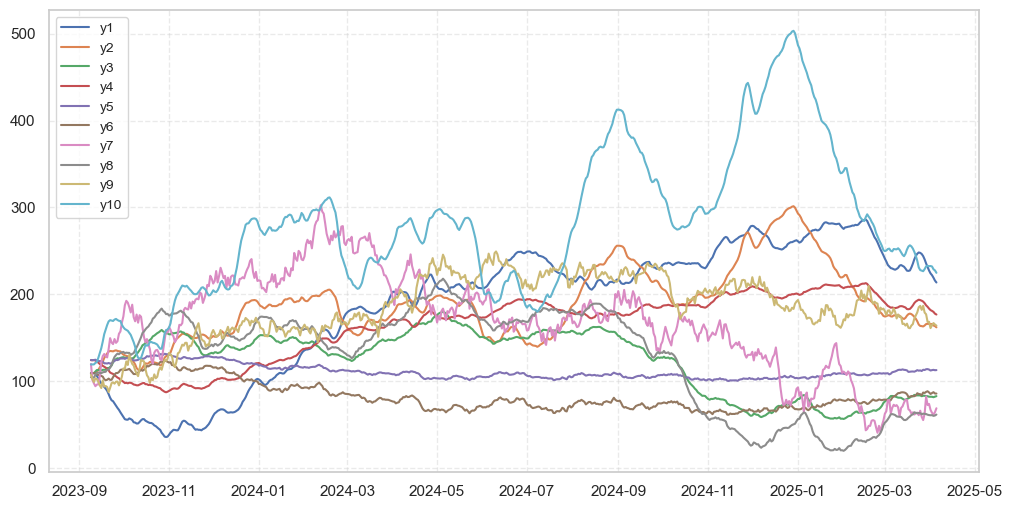

In [9]:
#Plot of variables in dataset
plt.figure(figsize=(12, 6))
plt.plot(df, label = df.columns.values)
plt.grid(linestyle = '--', alpha = 0.4)
plt.legend(loc = 'upper left', fontsize = 'small')
plt.show()

In [10]:
# Create first differences of each variable 
df['dy1'] = df['y1'].diff()
df['dy2'] = df['y2'].diff()
df['dy3'] = df['y3'].diff()
df['dy4'] = df['y4'].diff()
df['dy5'] = df['y5'].diff()
df['dy6'] = df['y6'].diff()
df['dy7'] = df['y7'].diff()
df['dy8'] = df['y8'].diff()
df['dy9'] = df['y9'].diff()
df['dy10'] = df['y10'].diff()

In [11]:
#ADF test creation for cointegration analysis
def adf_test(series, max_aug=10, version='c'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4); 
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4); 
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10, 
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)', 
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)', 
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)', 
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']
    
    return results_df


In [ ]:
#We will assume alpha=5% level for interpretation of all statistical tests

In [12]:
# ADF test for `y1`
adf_test(df['y1']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.1336934755,-3.4340000000,-2.8630000000,-2.5680000000,410.2961000000,0.0000000000,427.3515000000,0.0000000000,430.4951000000,0.0000000000,431.7512000000,0.0000000000
1,1,-1.3639695631,-3.4340000000,-2.8630000000,-2.5680000000,34.0159000000,0.0000000000,63.8021000000,0.0000000000,70.7896000000,0.0000000000,76.9371000000,0.0000000000
2,2,-1.1758716648,-3.4340000000,-2.8630000000,-2.5680000000,12.4360000000,0.0004000000,33.9837000000,0.0000000000,40.9926000000,0.0000000000,48.3875000000,0.0000000000
3,3,-1.1344141052,-3.4340000000,-2.8630000000,-2.5680000000,10.7458000000,0.0010000000,23.7983000000,0.0002000000,32.2780000000,0.0004000000,37.0253000000,0.0013000000
4,4,-1.3004105245,-3.4340000000,-2.8630000000,-2.5680000000,0.6391000000,0.4240000000,8.0554000000,0.1532000000,14.1444000000,0.1665000000,24.6716000000,0.0545000000
5,5,-1.2797185681,-3.4340000000,-2.8630000000,-2.5680000000,5.4454000000,0.0196000000,13.2055000000,0.0215000000,19.1675000000,0.0382000000,25.7565000000,0.0407000000
6,6,-1.2910704347,-3.4340000000,-2.8630000000,-2.5680000000,1.2720000000,0.2594000000,8.9866000000,0.1096000000,11.9008000000,0.2918000000,18.9714000000,0.2150000000
7,7,-1.3219757771,-3.4340000000,-2.8630000000,-2.5680000000,1.7460000000,0.1864000000,6.1195000000,0.2948000000,12.5978000000,0.2470000000,20.1543000000,0.1661000000
8,8,-1.2659160421,-3.4340000000,-2.8630000000,-2.5680000000,4.6751000000,0.0306000000,6.9005000000,0.2281000000,17.2453000000,0.0691000000,20.4645000000,0.1548000000
9,9,-1.3910229592,-3.4340000000,-2.8630000000,-2.5680000000,0.5093000000,0.4754000000,7.2003000000,0.2062000000,15.0099000000,0.1317000000,22.6700000000,0.0914000000


In [13]:
# ADF test for `dy1`
adf_test(df['dy1']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.8612734587,-3.4340000000,-2.8630000000,-2.5680000000,34.4703000000,0.0000000000,64.4254000000,0.0000000000,71.3359000000,0.0000000000,76.7495000000,0.0000000000
1,1,-8.4841425877,-3.4340000000,-2.8630000000,-2.5680000000,12.5545000000,0.0004000000,33.2698000000,0.0000000000,40.8556000000,0.0000000000,46.8689000000,0.0000000000
2,2,-9.2734079970,-3.4340000000,-2.8630000000,-2.5680000000,10.9282000000,0.0009000000,23.5807000000,0.0003000000,31.5928000000,0.0005000000,36.4723000000,0.0015000000
3,3,-7.3817740488,-3.4340000000,-2.8630000000,-2.5680000000,0.7455000000,0.3879000000,7.9635000000,0.1583000000,13.7556000000,0.1844000000,23.7996000000,0.0686000000
4,4,-7.3289507288,-3.4340000000,-2.8630000000,-2.5680000000,4.3071000000,0.0380000000,12.9039000000,0.0243000000,18.5544000000,0.0463000000,24.6919000000,0.0542000000
5,5,-7.7057963016,-3.4340000000,-2.8630000000,-2.5680000000,1.3407000000,0.2469000000,8.7618000000,0.1190000000,11.3163000000,0.3334000000,17.8751000000,0.2693000000
6,6,-6.8786753165,-3.4340000000,-2.8630000000,-2.5680000000,1.7860000000,0.1814000000,5.8018000000,0.3260000000,11.7877000000,0.2995000000,18.6134000000,0.2318000000
7,7,-6.9325771173,-3.4340000000,-2.8630000000,-2.5680000000,4.6107000000,0.0318000000,6.7138000000,0.2428000000,17.2106000000,0.0698000000,19.1701000000,0.2061000000
8,8,-6.1850202306,-3.4340000000,-2.8630000000,-2.5680000000,0.6425000000,0.4228000000,6.5905000000,0.2529000000,14.0230000000,0.1719000000,20.5629000000,0.1514000000
9,9,-6.2306163763,-3.4340000000,-2.8630000000,-2.5680000000,-0.5681000000,1.0000000000,7.9145000000,0.1610000000,10.9625000000,0.3604000000,15.9763000000,0.3836000000


In [ ]:
#Result: y1~I(1)

In [14]:
# ADF test for `y2`
adf_test(df['y2']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8822597171,-3.4340000000,-2.8630000000,-2.5680000000,425.7181000000,0.0000000000,449.7069000000,0.0000000000,452.5615000000,0.0000000000,453.1616000000,0.0000000000
1,1,-2.6157603140,-3.4340000000,-2.8630000000,-2.5680000000,47.3642000000,0.0000000000,97.9047000000,0.0000000000,102.8077000000,0.0000000000,104.6629000000,0.0000000000
2,2,-2.1496364941,-3.4340000000,-2.8630000000,-2.5680000000,26.6086000000,0.0000000000,57.3745000000,0.0000000000,60.4578000000,0.0000000000,62.2334000000,0.0000000000
3,3,-2.4049360991,-3.4340000000,-2.8630000000,-2.5680000000,12.3845000000,0.0004000000,33.3642000000,0.0000000000,38.7658000000,0.0000000000,40.0410000000,0.0004000000
4,4,-2.1935056626,-3.4340000000,-2.8630000000,-2.5680000000,12.8349000000,0.0003000000,25.2678000000,0.0001000000,30.1459000000,0.0008000000,31.6027000000,0.0073000000
5,5,-2.2673831114,-3.4340000000,-2.8630000000,-2.5680000000,5.9263000000,0.0149000000,12.6567000000,0.0268000000,16.7567000000,0.0799000000,17.6630000000,0.2808000000
6,6,-2.0950562734,-3.4340000000,-2.8630000000,-2.5680000000,2.4646000000,0.1164000000,3.1010000000,0.6844000000,8.1404000000,0.6151000000,9.6346000000,0.8421000000
7,7,-2.1268162270,-3.4340000000,-2.8630000000,-2.5680000000,0.0088000000,0.9254000000,4.4085000000,0.4922000000,6.5432000000,0.7677000000,8.2050000000,0.9153000000
8,8,-2.0161896703,-3.4340000000,-2.8630000000,-2.5680000000,0.0003000000,0.9869000000,0.2940000000,0.9978000000,8.5821000000,0.5722000000,10.2659000000,0.8027000000
9,9,-2.0628662544,-3.4340000000,-2.8630000000,-2.5680000000,0.7748000000,0.3787000000,4.3188000000,0.5045000000,6.0732000000,0.8091000000,9.5162000000,0.8490000000


In [15]:
# ADF test for `dy2`
adf_test(df['dy2']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5264261015,-3.4340000000,-2.8630000000,-2.5680000000,49.4352000000,0.0000000000,99.4710000000,0.0000000000,103.8406000000,0.0000000000,105.6099000000,0.0000000000
1,1,-8.5108319450,-3.4340000000,-2.8630000000,-2.5680000000,25.1371000000,0.0000000000,56.5251000000,0.0000000000,60.2453000000,0.0000000000,61.8927000000,0.0000000000
2,2,-6.4547703190,-3.4340000000,-2.8630000000,-2.5680000000,13.2432000000,0.0003000000,34.6242000000,0.0000000000,39.2896000000,0.0000000000,40.3723000000,0.0004000000
3,3,-7.2512492577,-3.4340000000,-2.8630000000,-2.5680000000,11.4218000000,0.0007000000,22.4273000000,0.0004000000,28.7420000000,0.0014000000,31.1664000000,0.0083000000
4,4,-6.0530363178,-3.4340000000,-2.8630000000,-2.5680000000,2.5527000000,0.1101000000,13.4716000000,0.0193000000,16.9595000000,0.0753000000,17.6737000000,0.2802000000
5,5,-6.5747441997,-3.4340000000,-2.8630000000,-2.5680000000,1.9583000000,0.1617000000,3.0217000000,0.6966000000,7.6603000000,0.6620000000,8.9673000000,0.8792000000
6,6,-5.9884128035,-3.4340000000,-2.8630000000,-2.5680000000,0.0331000000,0.8557000000,4.5996000000,0.4667000000,6.3734000000,0.7830000000,7.6892000000,0.9356000000
7,7,-5.9705493783,-3.4340000000,-2.8630000000,-2.5680000000,0.0100000000,0.9202000000,0.2143000000,0.9990000000,7.7447000000,0.6538000000,9.3393000000,0.8591000000
8,8,-5.5150496553,-3.4340000000,-2.8630000000,-2.5680000000,0.3905000000,0.5320000000,4.0894000000,0.5366000000,5.3505000000,0.8666000000,8.0173000000,0.9231000000
9,9,-5.0597388737,-3.4340000000,-2.8630000000,-2.5680000000,0.8463000000,0.3576000000,2.4249000000,0.7878000000,4.0264000000,0.9461000000,6.0733000000,0.9785000000


In [ ]:
#Result: y2~I(1)

In [16]:
# ADF test for `y3`
adf_test(df['y3']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,0.2354695736,-3.4340000000,-2.8630000000,-2.5680000000,231.7711000000,0.0000000000,250.7165000000,0.0000000000,253.6557000000,0.0000000000,256.0607000000,0.0000000000
1,1,-0.6162812661,-3.4340000000,-2.8630000000,-2.5680000000,23.1652000000,0.0000000000,34.4002000000,0.0000000000,36.9727000000,0.0001000000,41.3447000000,0.0003000000
2,2,-0.8869833581,-3.4340000000,-2.8630000000,-2.5680000000,4.6681000000,0.0307000000,12.7731000000,0.0256000000,16.6523000000,0.0824000000,19.9774000000,0.1728000000
3,3,-0.9844337470,-3.4340000000,-2.8630000000,-2.5680000000,4.5166000000,0.0336000000,7.3028000000,0.1991000000,11.8200000000,0.2973000000,15.6839000000,0.4034000000
4,4,-1.0883067443,-3.4340000000,-2.8630000000,-2.5680000000,1.4382000000,0.2304000000,7.0656000000,0.2158000000,9.9558000000,0.4444000000,14.0680000000,0.5204000000
5,5,-1.0492913716,-3.4340000000,-2.8630000000,-2.5680000000,2.8982000000,0.0887000000,4.8451000000,0.4351000000,7.4725000000,0.6802000000,11.4453000000,0.7204000000
6,6,-0.9567289672,-3.4340000000,-2.8630000000,-2.5680000000,0.9561000000,0.3282000000,2.6524000000,0.7534000000,3.6813000000,0.9606000000,14.3871000000,0.4964000000
7,7,-1.0272893575,-3.4340000000,-2.8630000000,-2.5680000000,0.0183000000,0.8925000000,1.2152000000,0.9434000000,3.3319000000,0.9725000000,13.4270000000,0.5694000000
8,8,-1.0096391366,-3.4340000000,-2.8630000000,-2.5680000000,0.0336000000,0.8546000000,3.0276000000,0.6957000000,11.2516000000,0.3383000000,19.7366000000,0.1823000000
9,9,-1.0672520361,-3.4340000000,-2.8630000000,-2.5680000000,0.0785000000,0.7794000000,4.8323000000,0.4367000000,12.9825000000,0.2247000000,16.0399000000,0.3794000000


In [17]:
# ADF test for `dy3`
adf_test(df['dy3']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-11.2798514364,-3.4340000000,-2.8630000000,-2.5680000000,22.7702000000,0.0000000000,33.8341000000,0.0000000000,36.2604000000,0.0001000000,40.5776000000,0.0004000000
1,1,-8.3141322978,-3.4340000000,-2.8630000000,-2.5680000000,4.4514000000,0.0349000000,14.2236000000,0.0142000000,16.1826000000,0.0945000000,19.4030000000,0.1961000000
2,2,-7.1975442664,-3.4340000000,-2.8630000000,-2.5680000000,4.3119000000,0.0378000000,7.4535000000,0.1890000000,11.6541000000,0.3089000000,15.4469000000,0.4197000000
3,3,-6.3928338182,-3.4340000000,-2.8630000000,-2.5680000000,1.5994000000,0.2060000000,7.1133000000,0.2124000000,9.7610000000,0.4617000000,13.7433000000,0.5451000000
4,4,-6.3532626566,-3.4340000000,-2.8630000000,-2.5680000000,0.3874000000,0.5337000000,5.0134000000,0.4142000000,7.2933000000,0.6975000000,11.0583000000,0.7485000000
5,5,-6.5784822293,-3.4340000000,-2.8630000000,-2.5680000000,0.4073000000,0.5233000000,2.6530000000,0.7533000000,3.6534000000,0.9616000000,14.3185000000,0.5015000000
6,6,-6.0337822998,-3.4340000000,-2.8630000000,-2.5680000000,-0.5299000000,1.0000000000,1.2908000000,0.9359000000,3.2376000000,0.9753000000,13.5304000000,0.5614000000
7,7,-5.8717410590,-3.4340000000,-2.8630000000,-2.5680000000,0.0573000000,0.8108000000,2.3621000000,0.7971000000,10.7673000000,0.3759000000,19.4756000000,0.1930000000
8,8,-5.4764629144,-3.4340000000,-2.8630000000,-2.5680000000,0.1222000000,0.7267000000,4.6984000000,0.4538000000,12.5202000000,0.2517000000,15.1274000000,0.4423000000
9,9,-5.4017379663,-3.4340000000,-2.8630000000,-2.5680000000,-4.7500000000,1.0000000000,4.8868000000,0.4298000000,14.9823000000,0.1327000000,18.9384000000,0.2165000000


In [ ]:
#Result: y3~I(1)

In [18]:
# ADF test for `y4`
adf_test(df['y4']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.1199037111,-3.4340000000,-2.8630000000,-2.5680000000,307.0295000000,0.0000000000,319.8005000000,0.0000000000,322.0431000000,0.0000000000,323.6104000000,0.0000000000
1,1,-1.1700655453,-3.4340000000,-2.8630000000,-2.5680000000,10.4217000000,0.0012000000,28.6552000000,0.0000000000,32.2512000000,0.0004000000,38.2140000000,0.0008000000
2,2,-1.2453384644,-3.4340000000,-2.8630000000,-2.5680000000,16.3984000000,0.0001000000,19.0326000000,0.0019000000,22.7334000000,0.0118000000,27.7245000000,0.0234000000
3,3,-1.1790245094,-3.4340000000,-2.8630000000,-2.5680000000,0.7248000000,0.3946000000,6.0566000000,0.3007000000,10.2003000000,0.4231000000,15.2610000000,0.4328000000
4,4,-1.2385605373,-3.4340000000,-2.8630000000,-2.5680000000,0.0219000000,0.8824000000,3.4849000000,0.6257000000,8.5108000000,0.5791000000,13.7635000000,0.5435000000
5,5,-1.2827223388,-3.4340000000,-2.8630000000,-2.5680000000,0.4787000000,0.4890000000,6.0901000000,0.2975000000,7.9549000000,0.6332000000,15.1556000000,0.4403000000
6,6,-1.2985308692,-3.4340000000,-2.8630000000,-2.5680000000,0.0957000000,0.7570000000,3.3604000000,0.6446000000,6.6825000000,0.7550000000,13.7819000000,0.5421000000
7,7,-1.3053912995,-3.4340000000,-2.8630000000,-2.5680000000,1.3204000000,0.2505000000,4.0456000000,0.5429000000,10.0360000000,0.4373000000,14.9801000000,0.4529000000
8,8,-1.2918720015,-3.4340000000,-2.8630000000,-2.5680000000,1.0709000000,0.3008000000,4.3386000000,0.5018000000,10.6482000000,0.3856000000,18.3765000000,0.2434000000
9,9,-1.3652632253,-3.4340000000,-2.8630000000,-2.5680000000,0.0963000000,0.7563000000,5.0684000000,0.4076000000,15.4410000000,0.1168000000,20.8829000000,0.1406000000


In [19]:
# ADF test for `dy4`
adf_test(df['dy4']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-9.3781577138,-3.4340000000,-2.8630000000,-2.5680000000,10.2119000000,0.0014000000,28.7911000000,0.0000000000,32.1946000000,0.0004000000,37.3941000000,0.0011000000
1,1,-7.5765420719,-3.4340000000,-2.8630000000,-2.5680000000,16.7064000000,0.0000000000,19.3440000000,0.0017000000,23.0595000000,0.0105000000,27.4340000000,0.0254000000
2,2,-8.5590523589,-3.4340000000,-2.8630000000,-2.5680000000,-1.8971000000,1.0000000000,5.8809000000,0.3180000000,9.6670000000,0.4702000000,14.6105000000,0.4798000000
3,3,-8.2450811758,-3.4340000000,-2.8630000000,-2.5680000000,0.0045000000,0.9465000000,3.2503000000,0.6615000000,7.9359000000,0.6351000000,13.0780000000,0.5963000000
4,4,-7.4421228862,-3.4340000000,-2.8630000000,-2.5680000000,-2.0484000000,1.0000000000,5.8856000000,0.3175000000,7.2610000000,0.7006000000,14.1312000000,0.5156000000
5,5,-7.4932206864,-3.4340000000,-2.8630000000,-2.5680000000,0.0538000000,0.8165000000,3.2296000000,0.6646000000,6.0124000000,0.8142000000,12.6625000000,0.6283000000
6,6,-6.9822658011,-3.4340000000,-2.8630000000,-2.5680000000,1.5000000000,0.2207000000,3.7154000000,0.5911000000,8.7076000000,0.5601000000,13.8382000000,0.5378000000
7,7,-7.0252761331,-3.4340000000,-2.8630000000,-2.5680000000,1.1907000000,0.2752000000,3.7309000000,0.5888000000,10.5784000000,0.3913000000,17.4630000000,0.2919000000
8,8,-6.3421882735,-3.4340000000,-2.8630000000,-2.5680000000,0.1486000000,0.6999000000,4.2701000000,0.5112000000,14.0881000000,0.1690000000,19.0406000000,0.2119000000
9,9,-6.1984410856,-3.4340000000,-2.8630000000,-2.5680000000,-2.9756000000,1.0000000000,6.9385000000,0.2253000000,12.7901000000,0.2356000000,17.1589000000,0.3095000000


In [ ]:
#Result: y4~I(1)

In [20]:
# ADF test for `y5`
adf_test(df['y5']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.6721795881,-3.4340000000,-2.8630000000,-2.5680000000,6.6833000000,0.0097000000,53.1125000000,0.0000000000,66.5886000000,0.0000000000,71.4609000000,0.0000000000
1,1,-1.7258804653,-3.4340000000,-2.8630000000,-2.5680000000,0.6155000000,0.4327000000,46.5095000000,0.0000000000,60.5408000000,0.0000000000,64.9449000000,0.0000000000
2,2,-1.7118650328,-3.4340000000,-2.8630000000,-2.5680000000,0.0036000000,0.9518000000,47.5567000000,0.0000000000,61.7567000000,0.0000000000,66.2177000000,0.0000000000
3,3,-1.7612843319,-3.4340000000,-2.8630000000,-2.5680000000,1.2974000000,0.2547000000,47.3944000000,0.0000000000,61.2976000000,0.0000000000,65.8214000000,0.0000000000
4,4,-1.9098070401,-3.4340000000,-2.8630000000,-2.5680000000,7.3334000000,0.0068000000,23.5470000000,0.0003000000,24.7571000000,0.0058000000,32.3106000000,0.0058000000
5,5,-1.7380689524,-3.4340000000,-2.8630000000,-2.5680000000,0.9069000000,0.3409000000,11.8149000000,0.0374000000,15.1929000000,0.1252000000,24.6755000000,0.0545000000
6,6,-1.7063873397,-3.4340000000,-2.8630000000,-2.5680000000,3.7540000000,0.0527000000,15.1759000000,0.0096000000,15.9044000000,0.1024000000,27.7737000000,0.0230000000
7,7,-1.6023760059,-3.4340000000,-2.8630000000,-2.5680000000,7.4162000000,0.0065000000,14.2319000000,0.0142000000,23.0544000000,0.0105000000,29.8978000000,0.0123000000
8,8,-1.5336827013,-3.4340000000,-2.8630000000,-2.5680000000,1.4490000000,0.2287000000,4.8205000000,0.4382000000,14.5792000000,0.1482000000,17.5234000000,0.2885000000
9,9,-1.4080668330,-3.4340000000,-2.8630000000,-2.5680000000,0.3469000000,0.5559000000,1.8580000000,0.8684000000,15.6144000000,0.1112000000,19.8499000000,0.1778000000


In [21]:
# ADF test for `dy5`
adf_test(df['dy5']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-21.4808280360,-3.4340000000,-2.8630000000,-2.5680000000,0.6941000000,0.4048000000,46.0448000000,0.0000000000,60.7789000000,0.0000000000,65.1719000000,0.0000000000
1,1,-16.5070392741,-3.4340000000,-2.8630000000,-2.5680000000,0.0210000000,0.8847000000,47.7823000000,0.0000000000,62.1684000000,0.0000000000,66.6355000000,0.0000000000
2,2,-13.4242070279,-3.4340000000,-2.8630000000,-2.5680000000,0.9720000000,0.3242000000,47.4279000000,0.0000000000,61.9505000000,0.0000000000,66.4933000000,0.0000000000
3,3,-8.9702688313,-3.4340000000,-2.8630000000,-2.5680000000,5.9456000000,0.0148000000,24.5336000000,0.0002000000,25.7510000000,0.0041000000,33.6537000000,0.0038000000
4,4,-9.4936407548,-3.4340000000,-2.8630000000,-2.5680000000,0.9019000000,0.3423000000,11.6083000000,0.0406000000,16.4505000000,0.0874000000,25.8958000000,0.0391000000
5,5,-9.2044138379,-3.4340000000,-2.8630000000,-2.5680000000,3.2802000000,0.0701000000,16.0488000000,0.0067000000,16.5898000000,0.0839000000,27.8199000000,0.0227000000
6,6,-9.3809901397,-3.4340000000,-2.8630000000,-2.5680000000,6.7715000000,0.0093000000,14.9789000000,0.0105000000,22.9564000000,0.0109000000,30.1101000000,0.0115000000
7,7,-9.8166733491,-3.4340000000,-2.8630000000,-2.5680000000,1.1812000000,0.2771000000,4.8614000000,0.4330000000,14.5039000000,0.1512000000,17.0703000000,0.3147000000
8,8,-8.7578712093,-3.4340000000,-2.8630000000,-2.5680000000,0.2650000000,0.6067000000,2.0019000000,0.8489000000,14.5807000000,0.1481000000,18.5956000000,0.2326000000
9,9,-8.4310843273,-3.4340000000,-2.8630000000,-2.5680000000,-0.2394000000,1.0000000000,1.5076000000,0.9122000000,12.8554000000,0.2319000000,18.3144000000,0.2465000000


In [22]:
#Result: y5~I(1)

In [23]:
# ADF test for `y6`
adf_test(df['y6']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.6366324436,-3.4340000000,-2.8630000000,-2.5680000000,26.7084000000,0.0000000000,122.3256000000,0.0000000000,148.4741000000,0.0000000000,161.8129000000,0.0000000000
1,1,-1.7618812180,-3.4340000000,-2.8630000000,-2.5680000000,1.9667000000,0.1608000000,99.5721000000,0.0000000000,127.3804000000,0.0000000000,140.6833000000,0.0000000000
2,2,-1.7222445767,-3.4340000000,-2.8630000000,-2.5680000000,0.0420000000,0.8376000000,97.8941000000,0.0000000000,126.4666000000,0.0000000000,140.0984000000,0.0000000000
3,3,-1.7191707319,-3.4340000000,-2.8630000000,-2.5680000000,52.6978000000,0.0000000000,100.4545000000,0.0000000000,126.5409000000,0.0000000000,140.0856000000,0.0000000000
4,4,-1.9821093464,-3.4340000000,-2.8630000000,-2.5680000000,33.0795000000,0.0000000000,60.5981000000,0.0000000000,74.4654000000,0.0000000000,86.5012000000,0.0000000000
5,5,-1.7136567375,-3.4340000000,-2.8630000000,-2.5680000000,0.0048000000,0.9449000000,34.6245000000,0.0000000000,44.4804000000,0.0000000000,59.0412000000,0.0000000000
6,6,-1.7128366156,-3.4340000000,-2.8630000000,-2.5680000000,4.0848000000,0.0433000000,35.6661000000,0.0000000000,46.3358000000,0.0000000000,62.6232000000,0.0000000000
7,7,-1.5912157424,-3.4340000000,-2.8630000000,-2.5680000000,12.7497000000,0.0004000000,33.0971000000,0.0000000000,54.0425000000,0.0000000000,61.5795000000,0.0000000000
8,8,-1.5064209470,-3.4340000000,-2.8630000000,-2.5680000000,9.5130000000,0.0020000000,20.4602000000,0.0010000000,36.5726000000,0.0001000000,44.7202000000,0.0001000000
9,9,-1.4246959004,-3.4340000000,-2.8630000000,-2.5680000000,3.0966000000,0.0785000000,15.5362000000,0.0083000000,33.3548000000,0.0002000000,35.8550000000,0.0019000000


In [24]:
# ADF test for `dy6`
adf_test(df['dy6']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-19.2246034725,-3.4340000000,-2.8630000000,-2.5680000000,2.1252000000,0.1449000000,99.4275000000,0.0000000000,127.7615000000,0.0000000000,140.9958000000,0.0000000000
1,1,-15.8868594427,-3.4340000000,-2.8630000000,-2.5680000000,0.0566000000,0.8120000000,97.8183000000,0.0000000000,127.0158000000,0.0000000000,140.6099000000,0.0000000000
2,2,-13.3311296478,-3.4340000000,-2.8630000000,-2.5680000000,68.7057000000,0.0000000000,103.7229000000,0.0000000000,126.9708000000,0.0000000000,140.4344000000,0.0000000000
3,3,-8.1211446358,-3.4340000000,-2.8630000000,-2.5680000000,33.6757000000,0.0000000000,61.8046000000,0.0000000000,75.8000000000,0.0000000000,88.0165000000,0.0000000000
4,4,-9.8586354006,-3.4340000000,-2.8630000000,-2.5680000000,-0.0015000000,1.0000000000,34.8229000000,0.0000000000,45.4100000000,0.0000000000,60.1913000000,0.0000000000
5,5,-9.0846034889,-3.4340000000,-2.8630000000,-2.5680000000,0.1596000000,0.6895000000,36.7474000000,0.0000000000,47.3340000000,0.0000000000,62.9700000000,0.0000000000
6,6,-9.2841806170,-3.4340000000,-2.8630000000,-2.5680000000,12.8569000000,0.0003000000,33.6746000000,0.0000000000,53.9720000000,0.0000000000,61.4618000000,0.0000000000
7,7,-10.1717339240,-3.4340000000,-2.8630000000,-2.5680000000,8.9818000000,0.0027000000,20.8486000000,0.0009000000,36.4556000000,0.0001000000,44.8659000000,0.0001000000
8,8,-8.3429059809,-3.4340000000,-2.8630000000,-2.5680000000,2.8660000000,0.0905000000,15.6341000000,0.0080000000,31.9300000000,0.0004000000,34.4546000000,0.0029000000
9,9,-8.7169687214,-3.4340000000,-2.8630000000,-2.5680000000,-0.7607000000,1.0000000000,9.0126000000,0.1086000000,20.8015000000,0.0225000000,30.3771000000,0.0106000000


In [ ]:
#Result: y6~I(1)

In [25]:
# ADF test for `y7`
adf_test(df['y7']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.1706664172,-3.4340000000,-2.8630000000,-2.5680000000,0.2481000000,0.6184000000,4.5835000000,0.4688000000,19.9808000000,0.0294000000,25.8075000000,0.0401000000
1,1,-1.2208691641,-3.4340000000,-2.8630000000,-2.5680000000,0.1907000000,0.6623000000,4.2401000000,0.5154000000,21.2347000000,0.0195000000,26.6234000000,0.0320000000
2,2,-1.3189105584,-3.4340000000,-2.8630000000,-2.5680000000,0.2549000000,0.6137000000,3.3805000000,0.6415000000,20.8008000000,0.0225000000,25.8959000000,0.0391000000
3,3,-1.3558336764,-3.4340000000,-2.8630000000,-2.5680000000,0.8687000000,0.3513000000,2.9475000000,0.7081000000,22.0479000000,0.0149000000,27.1612000000,0.0274000000
4,4,-1.2367488738,-3.4340000000,-2.8630000000,-2.5680000000,1.6624000000,0.1973000000,11.2725000000,0.0462000000,25.2418000000,0.0049000000,31.1706000000,0.0083000000
5,5,-1.1336390527,-3.4340000000,-2.8630000000,-2.5680000000,4.7746000000,0.0289000000,20.7374000000,0.0009000000,23.6933000000,0.0085000000,28.6346000000,0.0179000000
6,6,-1.2427972521,-3.4340000000,-2.8630000000,-2.5680000000,4.1497000000,0.0416000000,18.4011000000,0.0025000000,22.0293000000,0.0150000000,25.6236000000,0.0422000000
7,7,-1.2239287065,-3.4340000000,-2.8630000000,-2.5680000000,0.1405000000,0.7077000000,6.4571000000,0.2642000000,15.2949000000,0.1217000000,21.8661000000,0.1114000000
8,8,-1.0424226872,-3.4340000000,-2.8630000000,-2.5680000000,0.8953000000,0.3440000000,7.4181000000,0.1914000000,10.6360000000,0.3866000000,21.2797000000,0.1281000000
9,9,-1.1412612703,-3.4340000000,-2.8630000000,-2.5680000000,6.1754000000,0.0130000000,11.1386000000,0.0487000000,11.6880000000,0.3065000000,20.6290000000,0.1491000000


In [26]:
# ADF test for `dy7`
adf_test(df['dy7']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.6187768191,-3.4340000000,-2.8630000000,-2.5680000000,0.1349000000,0.7135000000,4.4011000000,0.4932000000,20.1310000000,0.0280000000,26.1047000000,0.0369000000
1,1,-16.5615049832,-3.4340000000,-2.8630000000,-2.5680000000,0.1458000000,0.7026000000,3.7035000000,0.5928000000,19.7983000000,0.0312000000,25.5195000000,0.0434000000
2,2,-13.4902126526,-3.4340000000,-2.8630000000,-2.5680000000,0.8326000000,0.3615000000,3.8220000000,0.5753000000,21.3029000000,0.0191000000,27.0287000000,0.0285000000
3,3,-12.3670818938,-3.4340000000,-2.8630000000,-2.5680000000,1.9021000000,0.1678000000,11.1911000000,0.0477000000,24.5514000000,0.0063000000,31.2446000000,0.0081000000
4,4,-11.6266482390,-3.4340000000,-2.8630000000,-2.5680000000,4.2264000000,0.0398000000,19.8846000000,0.0013000000,22.9685000000,0.0109000000,28.5034000000,0.0186000000
5,5,-9.5389444355,-3.4340000000,-2.8630000000,-2.5680000000,4.1578000000,0.0414000000,18.4318000000,0.0025000000,21.8251000000,0.0160000000,25.9253000000,0.0388000000
6,6,-8.4523631443,-3.4340000000,-2.8630000000,-2.5680000000,0.2072000000,0.6490000000,6.3082000000,0.2774000000,15.0721000000,0.1295000000,22.3214000000,0.0996000000
7,7,-8.5442254057,-3.4340000000,-2.8630000000,-2.5680000000,0.7272000000,0.3938000000,7.3818000000,0.1938000000,10.3046000000,0.4142000000,21.3808000000,0.1251000000
8,8,-7.6400587384,-3.4340000000,-2.8630000000,-2.5680000000,5.5452000000,0.0185000000,11.0368000000,0.0507000000,11.5656000000,0.3152000000,21.0771000000,0.1344000000
9,9,-6.5477990445,-3.4340000000,-2.8630000000,-2.5680000000,3.2477000000,0.0715000000,9.0746000000,0.1061000000,13.2435000000,0.2104000000,16.3248000000,0.3608000000


In [ ]:
#Result: y7~I(1)

In [27]:
# ADF test for `y8`
adf_test(df['y8']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,0.2317299726,-3.4340000000,-2.8630000000,-2.5680000000,215.2917000000,0.0000000000,238.2838000000,0.0000000000,241.9070000000,0.0000000000,243.3081000000,0.0000000000
1,1,-0.5835006825,-3.4340000000,-2.8630000000,-2.5680000000,28.2150000000,0.0000000000,40.7346000000,0.0000000000,42.2424000000,0.0000000000,45.6167000000,0.0001000000
2,2,-0.8781161493,-3.4340000000,-2.8630000000,-2.5680000000,3.4672000000,0.0626000000,16.3974000000,0.0058000000,17.8830000000,0.0570000000,19.7355000000,0.1823000000
3,3,-0.9537607145,-3.4340000000,-2.8630000000,-2.5680000000,4.4369000000,0.0352000000,8.7799000000,0.1182000000,13.2245000000,0.2114000000,15.3647000000,0.4255000000
4,4,-1.0846100404,-3.4340000000,-2.8630000000,-2.5680000000,0.6170000000,0.4322000000,7.7266000000,0.1720000000,9.2379000000,0.5097000000,11.7165000000,0.7003000000
5,5,-1.0586980198,-3.4340000000,-2.8630000000,-2.5680000000,2.1774000000,0.1400000000,5.7228000000,0.3341000000,7.6212000000,0.6658000000,9.9290000000,0.8242000000
6,6,-0.9358814976,-3.4340000000,-2.8630000000,-2.5680000000,1.0168000000,0.3133000000,2.2469000000,0.8140000000,3.5159000000,0.9666000000,11.1599000000,0.7412000000
7,7,-1.0091999153,-3.4340000000,-2.8630000000,-2.5680000000,0.0062000000,0.9370000000,0.8530000000,0.9735000000,2.2304000000,0.9943000000,8.6375000000,0.8957000000
8,8,-1.0054324949,-3.4340000000,-2.8630000000,-2.5680000000,0.1580000000,0.6910000000,2.1187000000,0.8325000000,7.7585000000,0.6524000000,15.7423000000,0.3994000000
9,9,-1.0475969276,-3.4340000000,-2.8630000000,-2.5680000000,0.0020000000,0.9642000000,3.4259000000,0.6346000000,8.7490000000,0.5561000000,13.1545000000,0.5904000000


In [28]:
# ADF test for `dy8`
adf_test(df['dy8']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-11.7124257927,-3.4340000000,-2.8630000000,-2.5680000000,27.7990000000,0.0000000000,40.1804000000,0.0000000000,41.5805000000,0.0000000000,44.6916000000,0.0001000000
1,1,-8.3884465374,-3.4340000000,-2.8630000000,-2.5680000000,3.2865000000,0.0699000000,16.0417000000,0.0067000000,17.4663000000,0.0647000000,19.2096000000,0.2044000000
2,2,-7.3481320743,-3.4340000000,-2.8630000000,-2.5680000000,4.2081000000,0.0402000000,8.9077000000,0.1128000000,13.0126000000,0.2230000000,15.0763000000,0.4459000000
3,3,-6.4031642298,-3.4340000000,-2.8630000000,-2.5680000000,0.7333000000,0.3918000000,7.7877000000,0.1683000000,9.0989000000,0.5227000000,11.4244000000,0.7220000000
4,4,-6.3062391187,-3.4340000000,-2.8630000000,-2.5680000000,2.5254000000,0.1120000000,5.9415000000,0.3119000000,7.4690000000,0.6805000000,9.6083000000,0.8436000000
5,5,-6.6426884598,-3.4340000000,-2.8630000000,-2.5680000000,0.9297000000,0.3349000000,2.0563000000,0.8413000000,3.8443000000,0.9541000000,11.4139000000,0.7227000000
6,6,-6.0923849799,-3.4340000000,-2.8630000000,-2.5680000000,0.0216000000,0.8831000000,0.8778000000,0.9718000000,2.0589000000,0.9959000000,8.4312000000,0.9053000000
7,7,-5.8752995666,-3.4340000000,-2.8630000000,-2.5680000000,0.1026000000,0.7488000000,2.3217000000,0.8031000000,7.3218000000,0.6948000000,15.5520000000,0.4124000000
8,8,-5.5226041953,-3.4340000000,-2.8630000000,-2.5680000000,0.0002000000,0.9883000000,3.2659000000,0.6591000000,8.2395000000,0.6055000000,13.2248000000,0.5849000000
9,9,-5.3749873901,-3.4340000000,-2.8630000000,-2.5680000000,1.2336000000,0.2667000000,6.4961000000,0.2609000000,8.9024000000,0.5414000000,15.2259000000,0.4353000000


In [29]:
#Result: y8~I(1)

In [30]:
# ADF test for `y9`
adf_test(df['y9']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.2731674167,-3.4340000000,-2.8630000000,-2.5680000000,0.1986000000,0.6558000000,3.0280000000,0.6957000000,6.0128000000,0.8142000000,12.0035000000,0.6788000000
1,1,-2.3474160271,-3.4340000000,-2.8630000000,-2.5680000000,0.3610000000,0.5480000000,3.9247000000,0.5603000000,6.6091000000,0.7618000000,12.7573000000,0.6210000000
2,2,-2.4554169201,-3.4340000000,-2.8630000000,-2.5680000000,0.6634000000,0.4154000000,2.8242000000,0.7271000000,5.7528000000,0.8356000000,11.7234000000,0.6998000000
3,3,-2.3576380062,-3.4340000000,-2.8630000000,-2.5680000000,0.2402000000,0.6241000000,3.1355000000,0.6791000000,6.6923000000,0.7541000000,12.5225000000,0.6391000000
4,4,-2.3325978965,-3.4340000000,-2.8630000000,-2.5680000000,0.7987000000,0.3715000000,2.7433000000,0.7395000000,8.1129000000,0.6178000000,14.2957000000,0.5032000000
5,5,-2.3807997449,-3.4340000000,-2.8630000000,-2.5680000000,1.6530000000,0.1986000000,7.1981000000,0.2063000000,10.0934000000,0.4323000000,16.2707000000,0.3643000000
6,6,-2.4582650533,-3.4340000000,-2.8630000000,-2.5680000000,1.9173000000,0.1662000000,6.2993000000,0.2782000000,10.2752000000,0.4167000000,16.0871000000,0.3763000000
7,7,-2.4989069128,-3.4340000000,-2.8630000000,-2.5680000000,1.9826000000,0.1591000000,4.1862000000,0.5229000000,7.4815000000,0.6793000000,13.5693000000,0.5584000000
8,8,-2.3602269126,-3.4340000000,-2.8630000000,-2.5680000000,1.3976000000,0.2371000000,4.9346000000,0.4239000000,6.2311000000,0.7955000000,13.2588000000,0.5823000000
9,9,-2.5244030098,-3.4340000000,-2.8630000000,-2.5680000000,0.0326000000,0.8567000000,1.0448000000,0.9589000000,2.4829000000,0.9911000000,10.0664000000,0.8155000000


In [31]:
# ADF test for `dy9`
adf_test(df['dy9']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.4522028669,-3.4340000000,-2.8630000000,-2.5680000000,0.0812000000,0.7757000000,3.8114000000,0.5769000000,6.6147000000,0.7612000000,12.6674000000,0.6280000000
1,1,-16.5668770832,-3.4340000000,-2.8630000000,-2.5680000000,1.0964000000,0.2951000000,3.3419000000,0.6474000000,6.3241000000,0.7873000000,12.0942000000,0.6719000000
2,2,-13.9381164268,-3.4340000000,-2.8630000000,-2.5680000000,0.4047000000,0.5247000000,2.8359000000,0.7253000000,6.2235000000,0.7961000000,12.1614000000,0.6668000000
3,3,-12.6594661016,-3.4340000000,-2.8630000000,-2.5680000000,0.6477000000,0.4209000000,1.9991000000,0.8493000000,7.4488000000,0.6825000000,14.2143000000,0.5093000000
4,4,-11.5055278900,-3.4340000000,-2.8630000000,-2.5680000000,1.2480000000,0.2639000000,6.6736000000,0.2461000000,9.2801000000,0.5057000000,15.5237000000,0.4144000000
5,5,-10.6636194248,-3.4340000000,-2.8630000000,-2.5680000000,1.7274000000,0.1887000000,5.9537000000,0.3107000000,8.9637000000,0.5355000000,14.9686000000,0.4537000000
6,6,-10.2883800448,-3.4340000000,-2.8630000000,-2.5680000000,1.7606000000,0.1845000000,3.6410000000,0.6022000000,7.2385000000,0.7028000000,13.4218000000,0.5698000000
7,7,-9.0753652971,-3.4340000000,-2.8630000000,-2.5680000000,1.2014000000,0.2730000000,3.2495000000,0.6616000000,4.8296000000,0.9023000000,12.1188000000,0.6700000000
8,8,-8.3089234545,-3.4340000000,-2.8630000000,-2.5680000000,0.0101000000,0.9199000000,0.7900000000,0.9777000000,2.6269000000,0.9889000000,10.5530000000,0.7836000000
9,9,-7.9075595397,-3.4340000000,-2.8630000000,-2.5680000000,0.3570000000,0.5502000000,2.8348000000,0.7254000000,7.4240000000,0.6849000000,12.3885000000,0.6494000000


In [ ]:
#Result: y9~I(1)

In [32]:
# ADF test for `y10`
adf_test(df['y10']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8841970367,-3.4340000000,-2.8630000000,-2.5680000000,424.8320000000,0.0000000000,446.6175000000,0.0000000000,448.9251000000,0.0000000000,449.7937000000,0.0000000000
1,1,-2.6105197595,-3.4340000000,-2.8630000000,-2.5680000000,44.9137000000,0.0000000000,87.3367000000,0.0000000000,91.9624000000,0.0000000000,94.8094000000,0.0000000000
2,2,-2.1572125995,-3.4340000000,-2.8630000000,-2.5680000000,23.4591000000,0.0000000000,47.4175000000,0.0000000000,51.3834000000,0.0000000000,54.0694000000,0.0000000000
3,3,-2.3880321292,-3.4340000000,-2.8630000000,-2.5680000000,10.0651000000,0.0015000000,26.0485000000,0.0001000000,33.1850000000,0.0003000000,35.2355000000,0.0023000000
4,4,-2.2158434286,-3.4340000000,-2.8630000000,-2.5680000000,11.4985000000,0.0007000000,20.5542000000,0.0010000000,27.1344000000,0.0025000000,29.5367000000,0.0137000000
5,5,-2.2500225144,-3.4340000000,-2.8630000000,-2.5680000000,4.5137000000,0.0336000000,9.3863000000,0.0946000000,14.2728000000,0.1609000000,16.4127000000,0.3552000000
6,6,-2.1211851993,-3.4340000000,-2.8630000000,-2.5680000000,1.4136000000,0.2345000000,2.0948000000,0.8359000000,8.5889000000,0.5715000000,11.1112000000,0.7447000000
7,7,-2.1000681212,-3.4340000000,-2.8630000000,-2.5680000000,0.2525000000,0.6153000000,4.1009000000,0.5350000000,8.0809000000,0.6209000000,11.1190000000,0.7441000000
8,8,-2.0400696030,-3.4340000000,-2.8630000000,-2.5680000000,0.7993000000,0.3713000000,1.5940000000,0.9020000000,9.9952000000,0.4409000000,13.3483000000,0.5754000000
9,9,-2.0439985379,-3.4340000000,-2.8630000000,-2.5680000000,0.3369000000,0.5616000000,4.3649000000,0.4982000000,7.0440000000,0.7213000000,12.7791000000,0.6194000000


In [33]:
# ADF test for `dy10`
adf_test(df['dy10']) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-6.5498339355,-3.4340000000,-2.8630000000,-2.5680000000,46.9409000000,0.0000000000,88.8667000000,0.0000000000,92.9935000000,0.0000000000,95.7079000000,0.0000000000
1,1,-8.4691134007,-3.4340000000,-2.8630000000,-2.5680000000,22.0677000000,0.0000000000,46.3786000000,0.0000000000,51.0895000000,0.0000000000,53.4932000000,0.0000000000
2,2,-6.5175642444,-3.4340000000,-2.8630000000,-2.5680000000,10.8611000000,0.0010000000,27.2425000000,0.0001000000,33.6782000000,0.0002000000,35.5019000000,0.0021000000
3,3,-7.2005973366,-3.4340000000,-2.8630000000,-2.5680000000,10.1311000000,0.0015000000,19.0368000000,0.0019000000,24.3167000000,0.0068000000,29.3831000000,0.0144000000
4,4,-6.1030210775,-3.4340000000,-2.8630000000,-2.5680000000,4.3882000000,0.0362000000,10.1735000000,0.0705000000,14.5389000000,0.1498000000,16.4982000000,0.3497000000
5,5,-6.5113665233,-3.4340000000,-2.8630000000,-2.5680000000,1.0206000000,0.3124000000,2.1472000000,0.8284000000,8.1432000000,0.6148000000,10.5545000000,0.7835000000
6,6,-6.0714771785,-3.4340000000,-2.8630000000,-2.5680000000,0.3530000000,0.5524000000,4.3293000000,0.5030000000,7.7331000000,0.6549000000,10.3859000000,0.7948000000
7,7,-5.9345210003,-3.4340000000,-2.8630000000,-2.5680000000,0.7358000000,0.3910000000,1.5559000000,0.9065000000,9.2835000000,0.5054000000,12.5279000000,0.6387000000
8,8,-5.5690146782,-3.4340000000,-2.8630000000,-2.5680000000,0.0832000000,0.7730000000,5.0274000000,0.4125000000,5.9377000000,0.8205000000,11.0986000000,0.7456000000
9,9,-5.0118793968,-3.4340000000,-2.8630000000,-2.5680000000,1.5562000000,0.2122000000,3.6003000000,0.6083000000,6.1205000000,0.8050000000,7.4279000000,0.9447000000


In [ ]:
#Result: y10~I(1)

FINAL RESULTS: each variable is a ~I(1) process, therefore VECM analysis is possible for each pair of assets

In [34]:
# Creation ofseveral models in order to find cointegrated assets (45 possibilities in total)
model_y1_y5 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y5']))).fit() 
model_y2_y6 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y6']))).fit()
model_y3_y7 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y7']))).fit()
model_y4_y8 = OLS(df['y4'], np.column_stack((np.ones(len(df)), df['y8']))).fit() 
model_y5_y9 = OLS(df['y5'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y6_y10 = OLS(df['y6'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y7_y1 = OLS(df['y7'], np.column_stack((np.ones(len(df)), df['y1']))).fit()
model_y8_y2 = OLS(df['y8'], np.column_stack((np.ones(len(df)), df['y2']))).fit()
model_y9_y3 = OLS(df['y9'], np.column_stack((np.ones(len(df)), df['y3']))).fit()
model_y10_y4 = OLS(df['y10'], np.column_stack((np.ones(len(df)), df['y4']))).fit() 
model_y1_y6 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y6']))).fit() 
model_y2_y7 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y7']))).fit()
model_y3_y8 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
model_y4_y9 = OLS(df['y4'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y5_y10 = OLS(df['y5'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y7 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y7']))).fit()
model_y2_y8 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
model_y3_y9 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y4_y10 = OLS(df['y4'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y8 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
model_y2_y9 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y3_y10 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y9 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y9']))).fit()
model_y2_y10 = OLS(df['y2'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y1_y10 = OLS(df['y1'], np.column_stack((np.ones(len(df)), df['y10']))).fit()
model_y6_y5 = OLS(df['y6'], np.column_stack((np.ones(len(df)), df['y5']))).fit()

In [35]:
# Test stationarity of residuals for model_y3_y8  
residuals = model_y3_y8.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.2455006056,-3.4340000000,-2.8630000000,-2.5680000000,0.0254000000,0.8734000000,1.6062000000,0.9005000000,4.0614000000,0.9445000000,10.0783000000,0.8148000000
1,1,-17.3776892316,-3.4340000000,-2.8630000000,-2.5680000000,0.2651000000,0.6067000000,2.0621000000,0.8405000000,4.4979000000,0.9221000000,10.5636000000,0.7829000000
2,2,-14.0539324208,-3.4340000000,-2.8630000000,-2.5680000000,0.0887000000,0.7658000000,6.3292000000,0.2755000000,8.6419000000,0.5664000000,14.6515000000,0.4768000000
3,3,-12.4969244786,-3.4340000000,-2.8630000000,-2.5680000000,-8.6086000000,1.0000000000,3.2004000000,0.6691000000,9.3711000000,0.4973000000,15.0535000000,0.4476000000
4,4,-11.4382490412,-3.4340000000,-2.8630000000,-2.5680000000,2.3281000000,0.1271000000,6.4451000000,0.2653000000,7.4932000000,0.6782000000,13.0903000000,0.5953000000
5,5,-10.5994607765,-3.4340000000,-2.8630000000,-2.5680000000,2.7238000000,0.0989000000,7.6697000000,0.1754000000,8.3723000000,0.5925000000,13.0726000000,0.5967000000
6,6,-9.0997121235,-3.4340000000,-2.8630000000,-2.5680000000,-0.0893000000,1.0000000000,4.8703000000,0.4319000000,5.5044000000,0.8550000000,10.4051000000,0.7935000000
7,7,-8.5761613486,-3.4340000000,-2.8630000000,-2.5680000000,-0.2051000000,1.0000000000,5.0347000000,0.4117000000,7.4946000000,0.6781000000,13.1044000000,0.5942000000
8,8,-7.9610594935,-3.4340000000,-2.8630000000,-2.5680000000,0.6982000000,0.4034000000,6.8609000000,0.2312000000,9.7069000000,0.4666000000,15.0792000000,0.4457000000
9,9,-7.3341944884,-3.4340000000,-2.8630000000,-2.5680000000,2.4733000000,0.1158000000,4.0399000000,0.5437000000,7.3170000000,0.6952000000,12.7793000000,0.6193000000


In [36]:
# Test stationarity of residuals for model_y2_y7
residuals = model_y2_y7.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.8931145591,-3.4340000000,-2.8630000000,-2.5680000000,277.0934000000,0.0000000000,283.0568000000,0.0000000000,290.3565000000,0.0000000000,293.5131000000,0.0000000000
1,1,-2.3339137371,-3.4340000000,-2.8630000000,-2.5680000000,8.8832000000,0.0029000000,13.3784000000,0.0201000000,27.5132000000,0.0022000000,32.2758000000,0.0059000000
2,2,-2.4484776388,-3.4340000000,-2.8630000000,-2.5680000000,1.5115000000,0.2189000000,5.2771000000,0.3830000000,16.6296000000,0.0830000000,22.2865000000,0.1005000000
3,3,-2.4808649455,-3.4340000000,-2.8630000000,-2.5680000000,0.6154000000,0.4327000000,3.8852000000,0.5661000000,15.5191000000,0.1143000000,20.4308000000,0.1560000000
4,4,-2.4840545066,-3.4340000000,-2.8630000000,-2.5680000000,0.1082000000,0.7422000000,7.7465000000,0.1708000000,18.4851000000,0.0473000000,23.5815000000,0.0725000000
5,5,-2.3464683503,-3.4340000000,-2.8630000000,-2.5680000000,0.1304000000,0.7180000000,12.1696000000,0.0325000000,18.4218000000,0.0483000000,23.6199000000,0.0718000000
6,6,-2.3709069280,-3.4340000000,-2.8630000000,-2.5680000000,0.0948000000,0.7581000000,9.4614000000,0.0920000000,14.5474000000,0.1495000000,18.0440000000,0.2604000000
7,7,-2.1721246175,-3.4340000000,-2.8630000000,-2.5680000000,2.2865000000,0.1305000000,6.6450000000,0.2484000000,14.0965000000,0.1686000000,14.9964000000,0.4517000000
8,8,-1.9981833420,-3.4340000000,-2.8630000000,-2.5680000000,3.3119000000,0.0688000000,11.3334000000,0.0452000000,12.8073000000,0.2346000000,15.1843000000,0.4382000000
9,9,-2.1171164418,-3.4340000000,-2.8630000000,-2.5680000000,2.1602000000,0.1416000000,6.5022000000,0.2604000000,9.5606000000,0.4799000000,12.7427000000,0.6222000000


In [38]:
# Test stationarity of residuals for model_y1_y6
residuals = model_y1_y6.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.2673977960,-3.4340000000,-2.8630000000,-2.5680000000,46.3354000000,0.0000000000,134.7616000000,0.0000000000,156.7035000000,0.0000000000,169.8127000000,0.0000000000
1,1,-3.0594828371,-3.4340000000,-2.8630000000,-2.5680000000,0.1524000000,0.6962000000,95.3157000000,0.0000000000,119.7146000000,0.0000000000,133.3106000000,0.0000000000
2,2,-2.9761469234,-3.4340000000,-2.8630000000,-2.5680000000,0.0736000000,0.7861000000,97.6647000000,0.0000000000,121.4704000000,0.0000000000,135.0123000000,0.0000000000
3,3,-2.9791724915,-3.4340000000,-2.8630000000,-2.5680000000,61.9061000000,0.0000000000,97.9575000000,0.0000000000,121.7284000000,0.0000000000,135.2755000000,0.0000000000
4,4,-4.1410971558,-3.4340000000,-2.8630000000,-2.5680000000,36.9057000000,0.0000000000,60.4120000000,0.0000000000,74.9518000000,0.0000000000,85.8888000000,0.0000000000
5,5,-3.0237376456,-3.4340000000,-2.8630000000,-2.5680000000,0.0171000000,0.8959000000,32.2610000000,0.0000000000,41.8241000000,0.0000000000,54.9894000000,0.0000000000
6,6,-2.9942963727,-3.4340000000,-2.8630000000,-2.5680000000,0.1892000000,0.6636000000,33.7885000000,0.0000000000,42.8705000000,0.0000000000,55.3937000000,0.0000000000
7,7,-2.6748574684,-3.4340000000,-2.8630000000,-2.5680000000,7.4005000000,0.0065000000,32.9590000000,0.0000000000,47.0643000000,0.0000000000,56.1057000000,0.0000000000
8,8,-2.2352313328,-3.4340000000,-2.8630000000,-2.5680000000,9.3273000000,0.0023000000,22.5064000000,0.0004000000,34.1342000000,0.0002000000,45.2640000000,0.0001000000
9,9,-2.5651999871,-3.4340000000,-2.8630000000,-2.5680000000,3.1109000000,0.0778000000,18.0637000000,0.0029000000,27.4110000000,0.0022000000,29.8967000000,0.0123000000


In [39]:
# Test stationarity of residuals for model_y10_y4
residuals = model_y10_y4.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.2169128019,-3.4340000000,-2.8630000000,-2.5680000000,415.3381000000,0.0000000000,423.3387000000,0.0000000000,424.2700000000,0.0000000000,424.8276000000,0.0000000000
1,1,-3.0369626093,-3.4340000000,-2.8630000000,-2.5680000000,21.0660000000,0.0000000000,28.7515000000,0.0000000000,32.1158000000,0.0004000000,32.7284000000,0.0051000000
2,2,-2.5267124520,-3.4340000000,-2.8630000000,-2.5680000000,5.7593000000,0.0164000000,8.9882000000,0.1095000000,11.7846000000,0.2997000000,12.2476000000,0.6602000000
3,3,-2.6783738383,-3.4340000000,-2.8630000000,-2.5680000000,1.0093000000,0.3151000000,4.9864000000,0.4175000000,9.5472000000,0.4811000000,11.4600000000,0.7194000000
4,4,-2.5460835319,-3.4340000000,-2.8630000000,-2.5680000000,1.5326000000,0.2157000000,3.7266000000,0.5894000000,8.8761000000,0.5439000000,10.9870000000,0.7535000000
5,5,-2.5518130180,-3.4340000000,-2.8630000000,-2.5680000000,0.0479000000,0.8267000000,4.5775000000,0.4696000000,6.6376000000,0.7592000000,7.8545000000,0.9295000000
6,6,-2.4908279306,-3.4340000000,-2.8630000000,-2.5680000000,0.0253000000,0.8737000000,4.2598000000,0.5127000000,7.9306000000,0.6356000000,8.7918000000,0.8881000000
7,7,-2.4937810505,-3.4340000000,-2.8630000000,-2.5680000000,1.5841000000,0.2082000000,5.9155000000,0.3145000000,8.2417000000,0.6052000000,9.4043000000,0.8554000000
8,8,-2.4891138363,-3.4340000000,-2.8630000000,-2.5680000000,2.4128000000,0.1204000000,4.7554000000,0.4465000000,10.1306000000,0.4291000000,11.3313000000,0.7288000000
9,9,-2.6209410402,-3.4340000000,-2.8630000000,-2.5680000000,0.1220000000,0.7269000000,1.9174000000,0.8605000000,3.3180000000,0.9729000000,6.0883000000,0.9782000000


In [40]:
# Test stationarity of residuals for model_y9_y3
residuals = model_y9_y3.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.2771349038,-3.4340000000,-2.8630000000,-2.5680000000,0.1545000000,0.6943000000,2.8428000000,0.7242000000,5.9186000000,0.8221000000,12.3508000000,0.6523000000
1,1,-2.3517924167,-3.4340000000,-2.8630000000,-2.5680000000,0.3941000000,0.5301000000,3.7710000000,0.5828000000,6.5485000000,0.7673000000,13.1652000000,0.5895000000
2,2,-2.4608981386,-3.4340000000,-2.8630000000,-2.5680000000,0.5511000000,0.4579000000,2.5923000000,0.7625000000,5.6231000000,0.8459000000,12.0436000000,0.6757000000
3,3,-2.3695611135,-3.4340000000,-2.8630000000,-2.5680000000,0.1519000000,0.6968000000,3.0079000000,0.6988000000,6.6654000000,0.7566000000,12.9257000000,0.6080000000
4,4,-2.3476555343,-3.4340000000,-2.8630000000,-2.5680000000,0.7897000000,0.3742000000,2.9194000000,0.7124000000,8.3212000000,0.5975000000,14.7723000000,0.4679000000
5,5,-2.3948260822,-3.4340000000,-2.8630000000,-2.5680000000,1.6365000000,0.2008000000,7.0484000000,0.2171000000,10.1637000000,0.4263000000,16.7877000000,0.3317000000
6,6,-2.4688833680,-3.4340000000,-2.8630000000,-2.5680000000,1.9343000000,0.1643000000,6.3254000000,0.2758000000,10.4547000000,0.4015000000,16.6319000000,0.3413000000
7,7,-2.5054328360,-3.4340000000,-2.8630000000,-2.5680000000,2.0064000000,0.1566000000,4.4501000000,0.4866000000,7.7434000000,0.6539000000,14.0301000000,0.5233000000
8,8,-2.3722579206,-3.4340000000,-2.8630000000,-2.5680000000,1.3499000000,0.2453000000,4.9676000000,0.4198000000,6.4543000000,0.7758000000,14.0136000000,0.5245000000
9,9,-2.5357543377,-3.4340000000,-2.8630000000,-2.5680000000,0.0279000000,0.8674000000,1.0018000000,0.9624000000,2.6369000000,0.9887000000,10.6548000000,0.7767000000


In [41]:
# Test stationarity of residuals for model_y8_y2
residuals = model_y8_y2.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-0.3190250678,-3.4340000000,-2.8630000000,-2.5680000000,284.6947000000,0.0000000000,299.7841000000,0.0000000000,301.6698000000,0.0000000000,302.5979000000,0.0000000000
1,1,-1.3298877822,-3.4340000000,-2.8630000000,-2.5680000000,18.0397000000,0.0000000000,32.4664000000,0.0000000000,33.2903000000,0.0002000000,35.2824000000,0.0022000000
2,2,-1.6246232336,-3.4340000000,-2.8630000000,-2.5680000000,4.3565000000,0.0369000000,17.4418000000,0.0037000000,19.1497000000,0.0384000000,20.5463000000,0.1520000000
3,3,-1.6674879480,-3.4340000000,-2.8630000000,-2.5680000000,5.5722000000,0.0182000000,9.5750000000,0.0882000000,12.6065000000,0.2465000000,15.2326000000,0.4348000000
4,4,-1.8674581825,-3.4340000000,-2.8630000000,-2.5680000000,0.1729000000,0.6775000000,4.1801000000,0.5238000000,5.3616000000,0.8657000000,8.6259000000,0.8963000000
5,5,-1.8400316179,-3.4340000000,-2.8630000000,-2.5680000000,1.4465000000,0.2291000000,4.6077000000,0.4656000000,5.8423000000,0.8283000000,8.6209000000,0.8965000000
6,6,-1.6846837028,-3.4340000000,-2.8630000000,-2.5680000000,0.7535000000,0.3854000000,1.5047000000,0.9125000000,3.2191000000,0.9758000000,8.6213000000,0.8965000000
7,7,-1.7573016805,-3.4340000000,-2.8630000000,-2.5680000000,0.2927000000,0.5885000000,1.1721000000,0.9475000000,2.6202000000,0.9890000000,10.4537000000,0.7903000000
8,8,-1.6664583076,-3.4340000000,-2.8630000000,-2.5680000000,0.0918000000,0.7620000000,1.0979000000,0.9543000000,4.5754000000,0.9177000000,11.5305000000,0.7142000000
9,9,-1.6764493538,-3.4340000000,-2.8630000000,-2.5680000000,0.0000000000,0.9969000000,1.6293000000,0.8977000000,7.4931000000,0.6782000000,11.8647000000,0.6892000000


In [42]:
# Test stationarity of residuals for model_y7_y1
residuals = model_y7_y1.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.5842776846,-3.4340000000,-2.8630000000,-2.5680000000,0.2933000000,0.5881000000,4.9614000000,0.4206000000,21.0503000000,0.0207000000,26.0628000000,0.0374000000
1,1,-1.7048005810,-3.4340000000,-2.8630000000,-2.5680000000,0.2604000000,0.6099000000,4.7114000000,0.4521000000,22.3830000000,0.0133000000,27.1065000000,0.0279000000
2,2,-1.8209221086,-3.4340000000,-2.8630000000,-2.5680000000,0.3223000000,0.5702000000,3.8274000000,0.5745000000,21.8772000000,0.0157000000,26.3377000000,0.0346000000
3,3,-1.8710089654,-3.4340000000,-2.8630000000,-2.5680000000,0.4167000000,0.5186000000,3.2447000000,0.6623000000,22.4278000000,0.0131000000,26.9089000000,0.0295000000
4,4,-1.7535235725,-3.4340000000,-2.8630000000,-2.5680000000,1.8254000000,0.1767000000,11.8438000000,0.0370000000,25.0345000000,0.0053000000,29.7216000000,0.0130000000
5,5,-1.6721302337,-3.4340000000,-2.8630000000,-2.5680000000,5.0202000000,0.0251000000,19.8635000000,0.0013000000,23.9369000000,0.0078000000,27.1799000000,0.0273000000
6,6,-1.7473011324,-3.4340000000,-2.8630000000,-2.5680000000,2.9830000000,0.0841000000,17.0861000000,0.0043000000,21.5941000000,0.0173000000,23.9649000000,0.0657000000
7,7,-1.6543944957,-3.4340000000,-2.8630000000,-2.5680000000,0.0350000000,0.8517000000,6.9114000000,0.2273000000,15.8397000000,0.1043000000,21.1063000000,0.1335000000
8,8,-1.4549087692,-3.4340000000,-2.8630000000,-2.5680000000,1.2861000000,0.2568000000,7.4367000000,0.1901000000,11.0394000000,0.3545000000,20.9404000000,0.1387000000
9,9,-1.5504967645,-3.4340000000,-2.8630000000,-2.5680000000,7.2721000000,0.0070000000,11.0257000000,0.0509000000,12.5649000000,0.2490000000,19.8838000000,0.1764000000


In [43]:
# Test stationarity of residuals for model_y6_y10
residuals = model_y6_y10.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.3770660551,-3.4340000000,-2.8630000000,-2.5680000000,42.4916000000,0.0000000000,138.1054000000,0.0000000000,158.8578000000,0.0000000000,173.3190000000,0.0000000000
1,1,-1.7887011083,-3.4340000000,-2.8630000000,-2.5680000000,0.0978000000,0.7545000000,103.1302000000,0.0000000000,126.0069000000,0.0000000000,140.3975000000,0.0000000000
2,2,-1.7597058501,-3.4340000000,-2.8630000000,-2.5680000000,0.6730000000,0.4120000000,103.6570000000,0.0000000000,126.4190000000,0.0000000000,140.8212000000,0.0000000000
3,3,-1.8182166446,-3.4340000000,-2.8630000000,-2.5680000000,67.0907000000,0.0000000000,104.3088000000,0.0000000000,126.3338000000,0.0000000000,140.9298000000,0.0000000000
4,4,-2.5896624431,-3.4340000000,-2.8630000000,-2.5680000000,31.9225000000,0.0000000000,55.2016000000,0.0000000000,69.2586000000,0.0000000000,80.8125000000,0.0000000000
5,5,-2.0389947598,-3.4340000000,-2.8630000000,-2.5680000000,0.2093000000,0.6473000000,29.2644000000,0.0000000000,40.5019000000,0.0000000000,51.3997000000,0.0000000000
6,6,-2.0772987629,-3.4340000000,-2.8630000000,-2.5680000000,2.0133000000,0.1559000000,29.1597000000,0.0000000000,39.8615000000,0.0000000000,57.7193000000,0.0000000000
7,7,-1.9364956917,-3.4340000000,-2.8630000000,-2.5680000000,8.8459000000,0.0029000000,30.1207000000,0.0000000000,49.9047000000,0.0000000000,58.0629000000,0.0000000000
8,8,-1.6979831819,-3.4340000000,-2.8630000000,-2.5680000000,12.7845000000,0.0003000000,19.9333000000,0.0013000000,33.2925000000,0.0002000000,45.6475000000,0.0001000000
9,9,-1.8887919467,-3.4340000000,-2.8630000000,-2.5680000000,3.1514000000,0.0759000000,13.9212000000,0.0161000000,31.9257000000,0.0004000000,35.1125000000,0.0024000000


In [44]:
# Test stationarity of residuals for model_y1_y5
residuals = model_y1_y5.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.4295143824,-3.4340000000,-2.8630000000,-2.5680000000,18.3779000000,0.0000000000,64.1084000000,0.0000000000,75.1737000000,0.0000000000,81.2129000000,0.0000000000
1,1,-2.9100203350,-3.4340000000,-2.8630000000,-2.5680000000,0.1195000000,0.7296000000,46.3835000000,0.0000000000,58.5159000000,0.0000000000,63.9121000000,0.0000000000
2,2,-2.9318899044,-3.4340000000,-2.8630000000,-2.5680000000,1.0866000000,0.2972000000,50.5526000000,0.0000000000,61.4167000000,0.0000000000,66.7014000000,0.0000000000
3,3,-3.0375383327,-3.4340000000,-2.8630000000,-2.5680000000,17.2861000000,0.0000000000,52.2354000000,0.0000000000,61.0004000000,0.0000000000,66.4548000000,0.0000000000
4,4,-3.8513512245,-3.4340000000,-2.8630000000,-2.5680000000,9.5419000000,0.0020000000,24.8592000000,0.0001000000,26.5367000000,0.0031000000,36.1631000000,0.0017000000
5,5,-3.2054913785,-3.4340000000,-2.8630000000,-2.5680000000,1.2575000000,0.2621000000,10.3053000000,0.0670000000,15.5556000000,0.1131000000,25.4643000000,0.0440000000
6,6,-2.9919249486,-3.4340000000,-2.8630000000,-2.5680000000,4.1069000000,0.0427000000,15.0304000000,0.0102000000,16.1578000000,0.0952000000,25.3844000000,0.0450000000
7,7,-2.6652422105,-3.4340000000,-2.8630000000,-2.5680000000,4.4663000000,0.0346000000,15.8278000000,0.0074000000,19.6645000000,0.0326000000,28.4161000000,0.0191000000
8,8,-2.3389482550,-3.4340000000,-2.8630000000,-2.5680000000,1.8242000000,0.1768000000,7.9710000000,0.1578000000,15.8201000000,0.1049000000,19.8089000000,0.1794000000
9,9,-2.4550990658,-3.4340000000,-2.8630000000,-2.5680000000,0.3071000000,0.5795000000,4.6229000000,0.4636000000,12.2533000000,0.2685000000,16.0272000000,0.3802000000


In [45]:
# Test stationarity of residuals for model_y2_y6
residuals = model_y2_y6.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.2696427343,-3.4340000000,-2.8630000000,-2.5680000000,155.4283000000,0.0000000000,226.6289000000,0.0000000000,236.7760000000,0.0000000000,246.8926000000,0.0000000000
1,1,-2.0086810181,-3.4340000000,-2.8630000000,-2.5680000000,3.5835000000,0.0584000000,99.4960000000,0.0000000000,113.1959000000,0.0000000000,124.6268000000,0.0000000000
2,2,-2.1471255195,-3.4340000000,-2.8630000000,-2.5680000000,6.2059000000,0.0127000000,96.2187000000,0.0000000000,112.5720000000,0.0000000000,121.6767000000,0.0000000000
3,3,-2.3380953857,-3.4340000000,-2.8630000000,-2.5680000000,52.7107000000,0.0000000000,91.4299000000,0.0000000000,109.9155000000,0.0000000000,118.7806000000,0.0000000000
4,4,-3.1879707715,-3.4340000000,-2.8630000000,-2.5680000000,39.1948000000,0.0000000000,53.0712000000,0.0000000000,65.8972000000,0.0000000000,71.6444000000,0.0000000000
5,5,-2.4271308092,-3.4340000000,-2.8630000000,-2.5680000000,2.0790000000,0.1493000000,19.1204000000,0.0018000000,28.0605000000,0.0018000000,34.3548000000,0.0030000000
6,6,-2.5281392695,-3.4340000000,-2.8630000000,-2.5680000000,0.3253000000,0.5685000000,18.6098000000,0.0023000000,28.8730000000,0.0013000000,39.5541000000,0.0005000000
7,7,-2.4762636596,-3.4340000000,-2.8630000000,-2.5680000000,0.4600000000,0.4976000000,20.4931000000,0.0010000000,30.9350000000,0.0006000000,40.9771000000,0.0003000000
8,8,-2.2467849865,-3.4340000000,-2.8630000000,-2.5680000000,11.6729000000,0.0006000000,17.7571000000,0.0033000000,31.8203000000,0.0004000000,37.1001000000,0.0012000000
9,9,-2.6045936487,-3.4340000000,-2.8630000000,-2.5680000000,1.7039000000,0.1918000000,15.5720000000,0.0082000000,18.4338000000,0.0481000000,23.4177000000,0.0757000000


In [46]:
# Test stationarity of residuals for model_y3_y7
residuals = model_y3_y7.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.5213839215,-3.4340000000,-2.8630000000,-2.5680000000,5.8741000000,0.0154000000,18.1286000000,0.0028000000,42.6198000000,0.0000000000,46.5512000000,0.0000000000
1,1,-1.7039389718,-3.4340000000,-2.8630000000,-2.5680000000,6.0399000000,0.0140000000,11.9131000000,0.0360000000,38.8040000000,0.0000000000,41.8187000000,0.0002000000
2,2,-1.9342372325,-3.4340000000,-2.8630000000,-2.5680000000,2.4371000000,0.1185000000,3.9423000000,0.5578000000,30.9493000000,0.0006000000,33.6400000000,0.0038000000
3,3,-2.0584594083,-3.4340000000,-2.8630000000,-2.5680000000,0.0344000000,0.8528000000,4.9423000000,0.4230000000,30.9848000000,0.0006000000,33.5288000000,0.0040000000
4,4,-2.0624727171,-3.4340000000,-2.8630000000,-2.5680000000,0.3430000000,0.5581000000,12.7508000000,0.0258000000,33.6121000000,0.0002000000,36.0899000000,0.0017000000
5,5,-2.1123826386,-3.4340000000,-2.8630000000,-2.5680000000,11.5358000000,0.0007000000,18.3475000000,0.0025000000,33.4931000000,0.0002000000,36.4600000000,0.0015000000
6,6,-2.3783123607,-3.4340000000,-2.8630000000,-2.5680000000,6.2484000000,0.0124000000,16.6634000000,0.0052000000,22.6900000000,0.0120000000,26.6109000000,0.0321000000
7,7,-2.5241662773,-3.4340000000,-2.8630000000,-2.5680000000,0.0181000000,0.8930000000,6.4992000000,0.2606000000,16.2447000000,0.0928000000,21.2925000000,0.1277000000
8,8,-2.4002747050,-3.4340000000,-2.8630000000,-2.5680000000,2.8246000000,0.0928000000,8.1926000000,0.1459000000,14.5096000000,0.1510000000,24.1621000000,0.0624000000
9,9,-2.5886534365,-3.4340000000,-2.8630000000,-2.5680000000,7.4670000000,0.0063000000,10.4969000000,0.0623000000,12.1047000000,0.2781000000,20.5961000000,0.1502000000


In [47]:
# Test stationarity of residuals for model_y4_y8
residuals = model_y4_y8.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.6579822836,-3.4340000000,-2.8630000000,-2.5680000000,239.3154000000,0.0000000000,253.1796000000,0.0000000000,256.5652000000,0.0000000000,259.1229000000,0.0000000000
1,1,-1.4836856954,-3.4340000000,-2.8630000000,-2.5680000000,18.4010000000,0.0000000000,27.5352000000,0.0000000000,29.1578000000,0.0012000000,35.4444000000,0.0021000000
2,2,-1.5470548873,-3.4340000000,-2.8630000000,-2.5680000000,4.5642000000,0.0326000000,8.8469000000,0.1153000000,11.9673000000,0.2873000000,18.4069000000,0.2419000000
3,3,-1.4727994527,-3.4340000000,-2.8630000000,-2.5680000000,0.0375000000,0.8465000000,8.4630000000,0.1325000000,10.3682000000,0.4088000000,16.0391000000,0.3795000000
4,4,-1.5302573344,-3.4340000000,-2.8630000000,-2.5680000000,1.8578000000,0.1729000000,7.8249000000,0.1662000000,9.7776000000,0.4602000000,15.5498000000,0.4126000000
5,5,-1.6288620120,-3.4340000000,-2.8630000000,-2.5680000000,0.0383000000,0.8449000000,4.8141000000,0.4390000000,7.6397000000,0.6640000000,14.8320000000,0.4636000000
6,6,-1.6684856759,-3.4340000000,-2.8630000000,-2.5680000000,0.3693000000,0.5434000000,2.4820000000,0.7792000000,3.4960000000,0.9672000000,9.1849000000,0.8677000000
7,7,-1.6884993927,-3.4340000000,-2.8630000000,-2.5680000000,0.4953000000,0.4816000000,1.5325000000,0.9093000000,10.0511000000,0.4360000000,12.2904000000,0.6569000000
8,8,-1.6686519827,-3.4340000000,-2.8630000000,-2.5680000000,0.1544000000,0.6943000000,1.9977000000,0.8495000000,12.0165000000,0.2840000000,15.3599000000,0.4258000000
9,9,-1.7186592848,-3.4340000000,-2.8630000000,-2.5680000000,0.0082000000,0.9280000000,3.7035000000,0.5928000000,15.0108000000,0.1317000000,17.2712000000,0.3029000000


In [48]:
# Test stationarity of residuals for model_y5_y9
residuals = model_y5_y9.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.9598501264,-3.4340000000,-2.8630000000,-2.5680000000,0.0844000000,0.7715000000,6.6719000000,0.2462000000,13.0120000000,0.2230000000,15.0633000000,0.4469000000
1,1,-2.9775846652,-3.4340000000,-2.8630000000,-2.5680000000,0.1779000000,0.6732000000,6.7066000000,0.2434000000,12.9850000000,0.2245000000,15.0886000000,0.4451000000
2,2,-2.9165831982,-3.4340000000,-2.8630000000,-2.5680000000,0.8121000000,0.3675000000,8.2758000000,0.1417000000,14.5711000000,0.1485000000,16.6764000000,0.3386000000
3,3,-2.8908400219,-3.4340000000,-2.8630000000,-2.5680000000,0.5842000000,0.4447000000,9.7829000000,0.0816000000,15.2786000000,0.1222000000,17.2815000000,0.3023000000
4,4,-3.1116568984,-3.4340000000,-2.8630000000,-2.5680000000,1.1162000000,0.2907000000,8.9203000000,0.1123000000,13.2387000000,0.2106000000,15.1550000000,0.4403000000
5,5,-2.8810589522,-3.4340000000,-2.8630000000,-2.5680000000,4.4429000000,0.0350000000,8.4248000000,0.1343000000,14.3177000000,0.1590000000,16.6800000000,0.3384000000
6,6,-2.6470628198,-3.4340000000,-2.8630000000,-2.5680000000,1.9463000000,0.1630000000,8.1853000000,0.1463000000,14.0999000000,0.1685000000,16.5359000000,0.3474000000
7,7,-2.5395071455,-3.4340000000,-2.8630000000,-2.5680000000,2.0727000000,0.1500000000,9.1703000000,0.1025000000,12.3669000000,0.2612000000,14.6923000000,0.4738000000
8,8,-2.5966150719,-3.4340000000,-2.8630000000,-2.5680000000,2.8438000000,0.0917000000,8.2955000000,0.1407000000,10.2517000000,0.4187000000,13.5809000000,0.5575000000
9,9,-2.7213162077,-3.4340000000,-2.8630000000,-2.5680000000,0.0098000000,0.9213000000,0.9914000000,0.9633000000,2.3444000000,0.9930000000,3.9849000000,0.9978000000


In [49]:
# Test stationarity of residuals for model_y6_y5  
residuals = model_y6_y5.resid
adf_test(pd.Series(residuals)) 

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-24.1978028275,-3.4340000000,-2.8630000000,-2.5680000000,0.0632000000,0.8015000000,4.0840000000,0.5374000000,7.4841000000,0.6791000000,9.2041000000,0.8666000000
1,1,-16.9464259513,-3.4340000000,-2.8630000000,-2.5680000000,0.2388000000,0.6251000000,7.6863000000,0.1744000000,10.8787000000,0.3670000000,12.4971000000,0.6411000000
2,2,-13.2688593407,-3.4340000000,-2.8630000000,-2.5680000000,5.0343000000,0.0249000000,8.7624000000,0.1189000000,12.6383000000,0.2446000000,14.2688000000,0.5052000000
3,3,-12.3538905174,-3.4340000000,-2.8630000000,-2.5680000000,0.5717000000,0.4496000000,2.6697000000,0.7508000000,7.5712000000,0.6706000000,9.1078000000,0.8718000000
4,4,-10.7579520600,-3.4340000000,-2.8630000000,-2.5680000000,0.6317000000,0.4267000000,3.5086000000,0.6221000000,8.3179000000,0.5978000000,10.1340000000,0.8112000000
5,5,-9.5684236141,-3.4340000000,-2.8630000000,-2.5680000000,0.0022000000,0.9628000000,2.9383000000,0.7095000000,10.9145000000,0.3642000000,12.4384000000,0.6456000000
6,6,-9.3482932823,-3.4340000000,-2.8630000000,-2.5680000000,-0.3230000000,1.0000000000,1.4750000000,0.9159000000,6.3003000000,0.7894000000,15.6906000000,0.4029000000
7,7,-8.6371229897,-3.4340000000,-2.8630000000,-2.5680000000,0.7761000000,0.3783000000,4.3913000000,0.4946000000,9.9415000000,0.4456000000,13.5524000000,0.5597000000
8,8,-8.5445831060,-3.4340000000,-2.8630000000,-2.5680000000,0.7367000000,0.3907000000,5.1858000000,0.3936000000,8.8204000000,0.5492000000,12.4587000000,0.6440000000
9,9,-8.0521349775,-3.4340000000,-2.8630000000,-2.5680000000,3.3317000000,0.0680000000,4.3880000000,0.4950000000,8.3417000000,0.5955000000,10.4562000000,0.7901000000


FINAL RESULTS: basing on a graphs analysis and ADF tests results, we find several cointegrated variables:
- y5 and y6
- y3 and y8

In [50]:
#As a result, we will carry on with analysis of 'y3' and 'y8' variables
df = df[['y3', 'y8', 'dy3', 'dy8']]

In [51]:
# Add lagged residuals to the dataset
model_y3_y8 = OLS(df['y3'], np.column_stack((np.ones(len(df)), df['y8']))).fit()
residuals = model_y3_y8.resid
df['lresid'] = residuals.shift(1) 

Visualization and data exploration

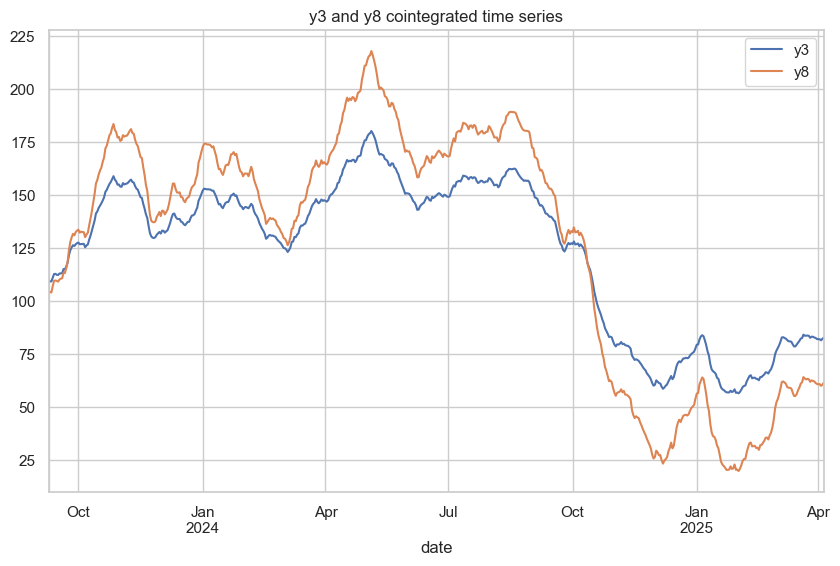

In [52]:
# Plot `y3` and `y8`
df[['y3', 'y8']].plot(figsize=(10, 6), title="y3 and y8 cointegrated time series")
plt.show() #doesn't seem like cointegrated assets

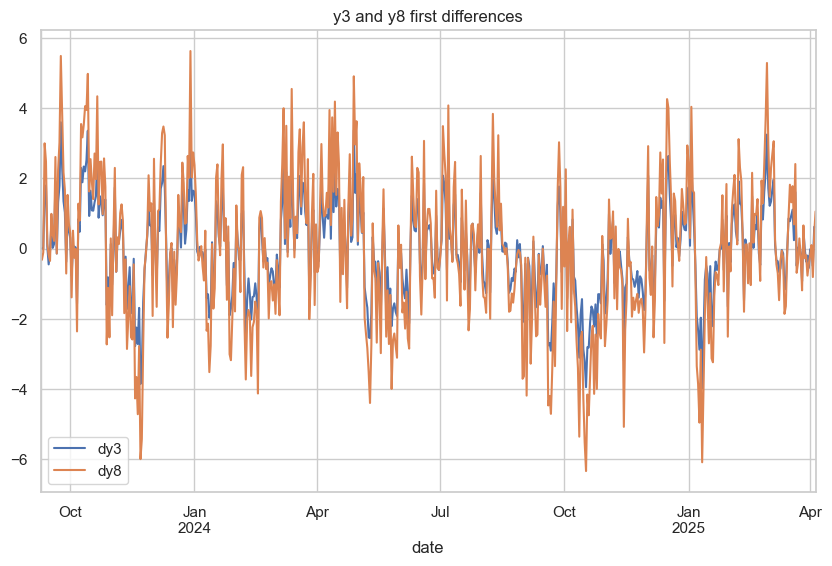

In [53]:
# Plot `dy3` and `dy8`
df[['dy3', 'dy8']].plot(figsize=(10, 6), title="y3 and y8 first differences")
plt.show()

## VECM model

In [54]:
# Granger causality tests
grangercausalitytests(df[['y3', 'y8']].dropna(), maxlag=5) #H0: no granger causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3533  , p=0.5525  , df_denom=571, df_num=1
ssr based chi2 test:   chi2=0.3551  , p=0.5512  , df=1
likelihood ratio test: chi2=0.3550  , p=0.5513  , df=1
parameter F test:         F=0.3533  , p=0.5525  , df_denom=571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0775  , p=0.9255  , df_denom=568, df_num=2
ssr based chi2 test:   chi2=0.1563  , p=0.9248  , df=2
likelihood ratio test: chi2=0.1563  , p=0.9248  , df=2
parameter F test:         F=0.0775  , p=0.9255  , df_denom=568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1783  , p=0.9111  , df_denom=565, df_num=3
ssr based chi2 test:   chi2=0.5416  , p=0.9097  , df=3
likelihood ratio test: chi2=0.5413  , p=0.9097  , df=3
parameter F test:         F=0.1783  , p=0.9111  , df_denom=565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1958  , p=0.9406  

{1: ({'ssr_ftest': (0.35327598889179573, 0.5524999259348284, 571.0, 1),
   'ssr_chi2test': (0.3551320799017351, 0.5512222627184111, 1),
   'lrtest': (0.3550222656169808, 0.5512838234113568, 1),
   'params_ftest': (0.3532759888913797, 0.552499925935078, 571.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.07748562372062379, 0.92545010929339, 568.0, 2),
   'ssr_chi2test': (0.15633543095745575, 0.9248093087001306, 2),
   'lrtest': (0.15631410781384147, 0.9248191686735445, 2),
   'params_ftest': (0.07748562372137655, 0.9254501092927186, 568.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.17832311355142352, 0.9110952430079496, 565.0, 3),
   'ssr_chi2test': (0.5415972793880404, 0.9096621105330503, 3),
   'lrtest': (0.5413410358682995, 0.9097194919520089, 3),
   'params_ftest': (0.1783231135515346, 0.9110952430078794, 565.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

In [ ]:
#Result: We fail to reject the null of no causality at the 5% level for each lags. 
#Hence, y3 is not a Granger cause of y8.

In [55]:
# Opposite relation
grangercausalitytests(df[['y8', 'y3']].dropna(), maxlag=5) #H0: no granger causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8503  , p=0.0919  , df_denom=571, df_num=1
ssr based chi2 test:   chi2=2.8653  , p=0.0905  , df=1
likelihood ratio test: chi2=2.8582  , p=0.0909  , df=1
parameter F test:         F=2.8503  , p=0.0919  , df_denom=571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.1616 , p=0.0000  , df_denom=568, df_num=2
ssr based chi2 test:   chi2=28.5726 , p=0.0000  , df=2
likelihood ratio test: chi2=27.8831 , p=0.0000  , df=2
parameter F test:         F=14.1616 , p=0.0000  , df_denom=568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0415  , p=0.0000  , df_denom=565, df_num=3
ssr based chi2 test:   chi2=24.4233 , p=0.0000  , df=3
likelihood ratio test: chi2=23.9162 , p=0.0000  , df=3
parameter F test:         F=8.0415  , p=0.0000  , df_denom=565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.9689  , p=0.0001  

{1: ({'ssr_ftest': (2.850334284367434, 0.09190096044312579, 571.0, 1),
   'ssr_chi2test': (2.865309770975319, 0.09050828303862742, 1),
   'lrtest': (2.8581819138125866, 0.09091019764018708, 1),
   'params_ftest': (2.8503342843672677, 0.09190096044312869, 571.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (14.161642805010628, 9.956464496897058e-07, 568.0, 2),
   'ssr_chi2test': (28.572610307292567, 6.245058414345114e-07, 2),
   'lrtest': (27.883054859163167, 8.815999726405833e-07, 2),
   'params_ftest': (14.161642805009539, 9.956464496907652e-07, 568.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (8.041463052709336, 2.9635682922304153e-05, 565.0, 3),
   'ssr_chi2test': (24.423275395485348, 2.037956533314955e-05, 3),
   'lrtest': (23.91624505784148, 2.600618649973181e-05, 3),
   'params_ftest': (8.041463052710146, 2.9635682922271725e-05, 565.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.]

In [ ]:
#Result: We reject the null of no causality at the 5% level for models with 2,3,4 lags. For 1 lag, we fail to reject the null with 5% level and reject with 10% level.
#Hence, y8 is a Granger cause of y3 (but the relationship is not fully certain)

In [56]:
#VAR preliminary model preparation

df_var = df.drop(columns=[col for col in df.columns if col not in ['y3', 'y8']])

# Fit a VAR model to the data
model = VAR(df_var)
results = model.select_order(maxlags=15)
print("\nLag selection results:")
print(results.summary())


Lag selection results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.920       3.935       50.40       3.926
1       -2.737      -2.691     0.06477      -2.719
2       -3.248     -3.171*     0.03886      -3.218
3       -3.278      -3.170     0.03769     -3.236*
4      -3.280*      -3.141    0.03762*      -3.226
5       -3.274      -3.104     0.03785      -3.208
6       -3.268      -3.067     0.03808      -3.190
7       -3.265      -3.033     0.03821      -3.174
8       -3.260      -2.998     0.03837      -3.158
9       -3.252      -2.958     0.03870      -3.137
10      -3.242      -2.917     0.03909      -3.115
11      -3.232      -2.876     0.03950      -3.093
12      -3.219      -2.832     0.04001      -3.068
13      -3.217      -2.799     0.04010      -3.054
14      -3.208      -2.759     0.04046      -3.033
15      -3.210      -2.731     0.04037      -3.023
-------

Information criteria for different lag orders:
  aic bic hqic fpe
1   1   1    1   1
2   2   2    2   2
3   3   2    3   3
4   4   2    3   4
5   4   3    3   4
6   4   3    3   4


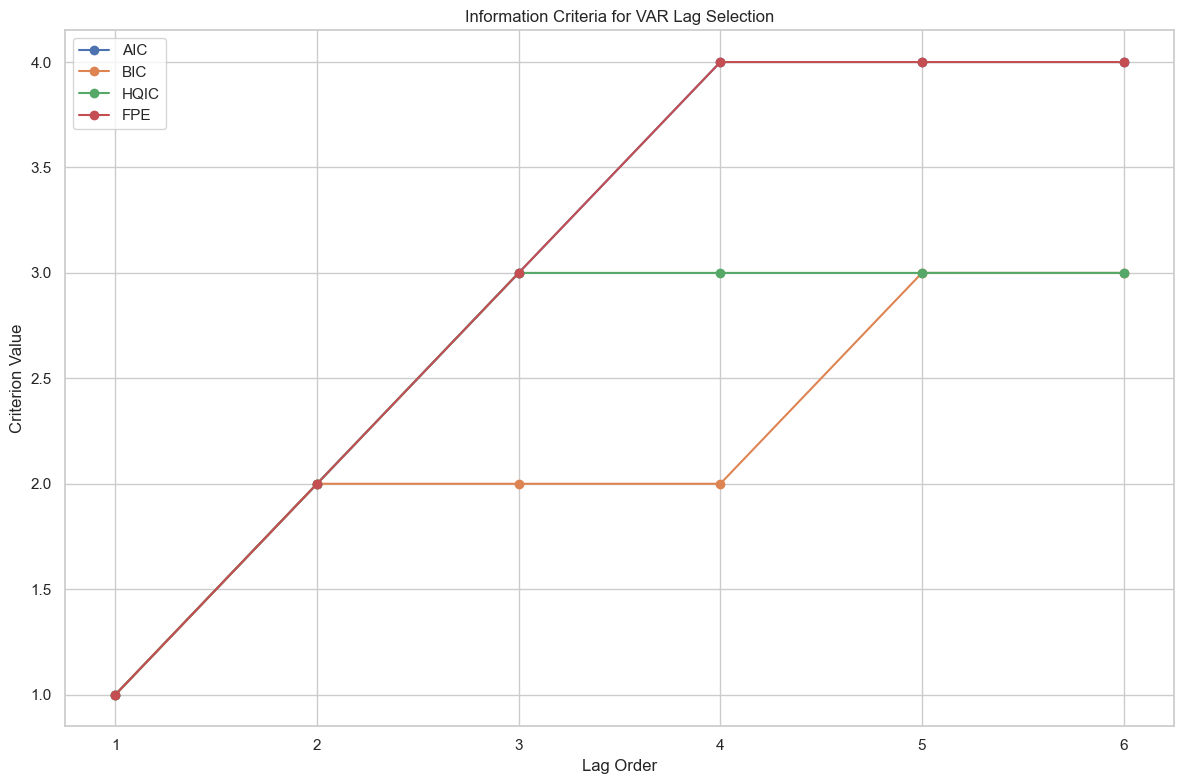

In [57]:
# Function to select optimal lag order
def select_var_order(data, max_lags=12):
    # Create a VAR model
    model = VAR(data)
    
    # Determine information criteria for different lag orders
    results = {}
    for i in range(1, max_lags + 1):
        results[i] = model.select_order(i)
    
    # Create a DataFrame to display the results
    criteria = ['aic', 'bic', 'hqic', 'fpe']
    order_df = pd.DataFrame(index=range(1, max_lags + 1), columns=criteria)
    
    for i in range(1, max_lags + 1):
        for criterion in criteria:
            order_df.loc[i, criterion] = getattr(results[i], criterion)
    
    return order_df

# Select optimal lag order
lag_order_results = select_var_order(df_var, max_lags=6)
print("Information criteria for different lag orders:")
print(lag_order_results)

# Plot the information criteria
plt.figure(figsize=(12, 8))
for column in lag_order_results.columns:
    plt.plot(lag_order_results.index, lag_order_results[column], marker='o', label=column.upper())
plt.xlabel('Lag Order')
plt.ylabel('Criterion Value')
plt.title('Information Criteria for VAR Lag Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Basing on a plot: lag=5

In [58]:
# Fit VAR(5) model
var5_model = VAR(df_var,freq='D')
var5_results = var5_model.fit(5)

# Print model summary
print(var5_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 03, Jul, 2025
Time:                     12:50:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.10783
Nobs:                     570.000    HQIC:                  -3.21012
Log likelihood:          -662.056    FPE:                  0.0377962
AIC:                     -3.27556    Det(Omega_mle):       0.0363785
--------------------------------------------------------------------
Results for equation y3
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -33.730835        34.505105           -0.978           0.328
L1.y3         1.603322         0.340447            4.709           0.000
L1.y8        -0.077842         0.210396           -0.370           0.711
L2.y3        -0.151042

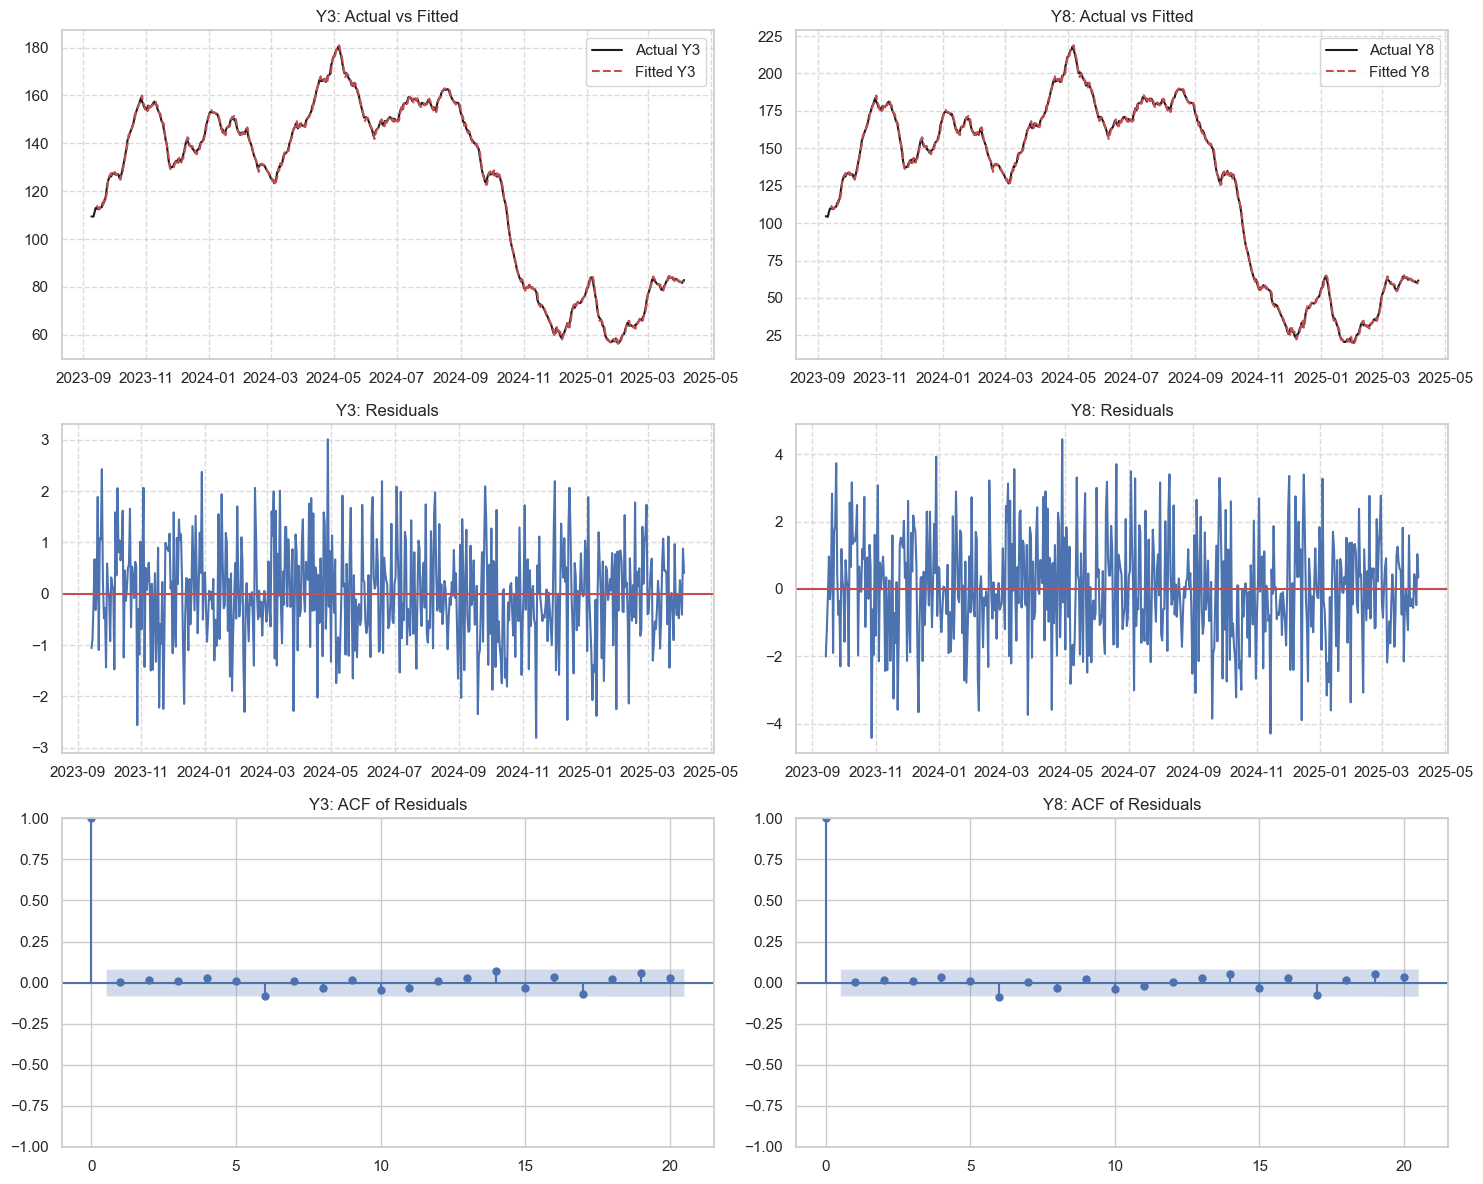

In [59]:
#VAR model diagnostics
# Plot fitted values vs actual values, residuals, and ACF/PACF
fig = plt.figure(figsize=(15, 12))

# Fitted values vs actual values for each variable
for i, name in enumerate(df_var.columns):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(df_var.index, df_var[name], 'k-', label=f'Actual {name.upper()}')
    ax.plot(var5_results.fittedvalues[name].index, var5_results.fittedvalues[name], 'r--', 
            label=f'Fitted {name.upper()}')
    ax.set_title(f'{name.upper()}: Actual vs Fitted')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Residuals for each variable
for i, name in enumerate(df_var.columns):
    ax = fig.add_subplot(3, 2, i+3)
    residuals = var5_results.resid[name]
    ax.plot(residuals.index, residuals, 'b-')
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_title(f'{name.upper()}: Residuals')
    ax.grid(True, linestyle='--', alpha=0.7)

# ACF and PACF for residuals
for i, name in enumerate(df_var.columns):
    ax = fig.add_subplot(3, 2, i+5)
    residuals = var5_results.resid[name].values
    plot_acf(residuals, ax=ax, lags=20, alpha=0.05, title=f'{name.upper()}: ACF of Residuals')

plt.tight_layout()
plt.show() 

In [60]:
# Perform Ljung-Box test for autocorrelation of residuals (equivalent to Portmanteau test)
residuals = var5_results.resid

print("Ljung-Box Test for Residual Autocorrelation:")
for name in residuals.columns:
    lb_test = acorr_ljungbox(residuals[name], lags=[5, 10, 15, 20])
    print(f"\n{name.upper()} series:")
    print(f"Lag 5: p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"Lag 10: p-value = {lb_test.iloc[1, 1]:.4f}")
    print(f"Lag 15: p-value = {lb_test.iloc[2, 1]:.4f}")
    print(f"Lag 20: p-value = {lb_test.iloc[3, 1]:.4f}")

Ljung-Box Test for Residual Autocorrelation:

Y3 series:
Lag 5: p-value = 0.9820
Lag 10: p-value = 0.7432
Lag 15: p-value = 0.7342
Lag 20: p-value = 0.6048

Y8 series:
Lag 5: p-value = 0.9674
Lag 10: p-value = 0.7034
Lag 15: p-value = 0.8060
Lag 20: p-value = 0.6868


In [15]:
#Result: no autocorrelation in residuals for each lag and variable, so we can proceed with the model

In [61]:
# Why such a VAR model estimation? For VECM Johansen Cointegration test!
# Perform Johansen test
# K=5 in levels VAR -> k_ar_diff = K-1 = 4 lags in VECM differences
# ecdet = "const" -> det_order = 0 (constant in CE)

data_for_test = df[['y3', 'y8']]
johansen_result = coint_johansen(data_for_test, det_order=0, k_ar_diff=4)

print("Johansen Test Results:")
print("Eigenvalues:")
print(johansen_result.eig)
print("\nTrace Statistic:")
print(johansen_result.lr1)
print("\nCritical Values (90%, 95%, 99%) for Trace Statistic:")
print(johansen_result.cvt)
print("\nMaximum Eigenvalue Statistic:")
print(johansen_result.lr2)
print("\nCritical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:")
print(johansen_result.cvm)

Johansen Test Results:
Eigenvalues:
[0.18809951 0.00214208]

Trace Statistic:
[119.99746771   1.22229641]

Critical Values (90%, 95%, 99%) for Trace Statistic:
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Maximum Eigenvalue Statistic:
[118.77517131   1.22229641]

Critical Values (90%, 95%, 99%) for Max Eigenvalue Statistic:
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [62]:
#Automation of Johansen interpretation
print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 1]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvm[i, 1]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 119.997
  Critical Value (95%): 15.494
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 1.222
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 118.775
  Critical Value (95%): 14.264
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 1.222
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.


In [ ]:
#Exactly one cointegrating vector!

In [63]:
print("Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):")
print(johansen_result.evec)

print("\nCointegrating Vector (beta - first column of eigenvectors):")
coint_vector_raw = johansen_result.evec[:, 0]
print(coint_vector_raw)

# Normalize the first element to 1 for potentially easier interpretation
coint_vector_normalized = coint_vector_raw / coint_vector_raw[0]
print("\nCointegrating Vector (beta, normalized with y8 coefficient = 1):")
print(coint_vector_normalized)

Eigenvectors (columns are potential cointegrating vectors, ordered by eigenvalue):
[[ 19.14438213  -0.09315514]
 [-11.96437858   0.07575096]]

Cointegrating Vector (beta - first column of eigenvectors):
[ 19.14438213 -11.96437858]

Cointegrating Vector (beta, normalized with y8 coefficient = 1):
[ 1.         -0.62495506]


In [64]:
# Estimate VECM
vecm_model = VECM(data_for_test, k_ar_diff=4, coint_rank=1, deterministic='ci')
vecm_results = vecm_model.fit()

In [65]:
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y3
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y3         -0.1569      0.689     -0.228      0.820      -1.507       1.193
L1.y8          0.3986      0.429      0.929      0.353      -0.442       1.239
L2.y3         -0.3119      0.593     -0.526      0.599      -1.475       0.851
L2.y8          0.2852      0.369      0.773      0.440      -0.438       1.009
L3.y3         -0.1984      0.479     -0.415      0.678      -1.136       0.740
L3.y8          0.1571      0.298      0.527      0.598      -0.427       0.741
L4.y3         -0.1385      0.334     -0.414      0.679      -0.794       0.517
L4.y8          0.1361      0.208      0.654      0.513      -0.272       0.544
Det. terms outside the coint. relation & lagged endog. parameters for equation y8
                 coef    std err          z   

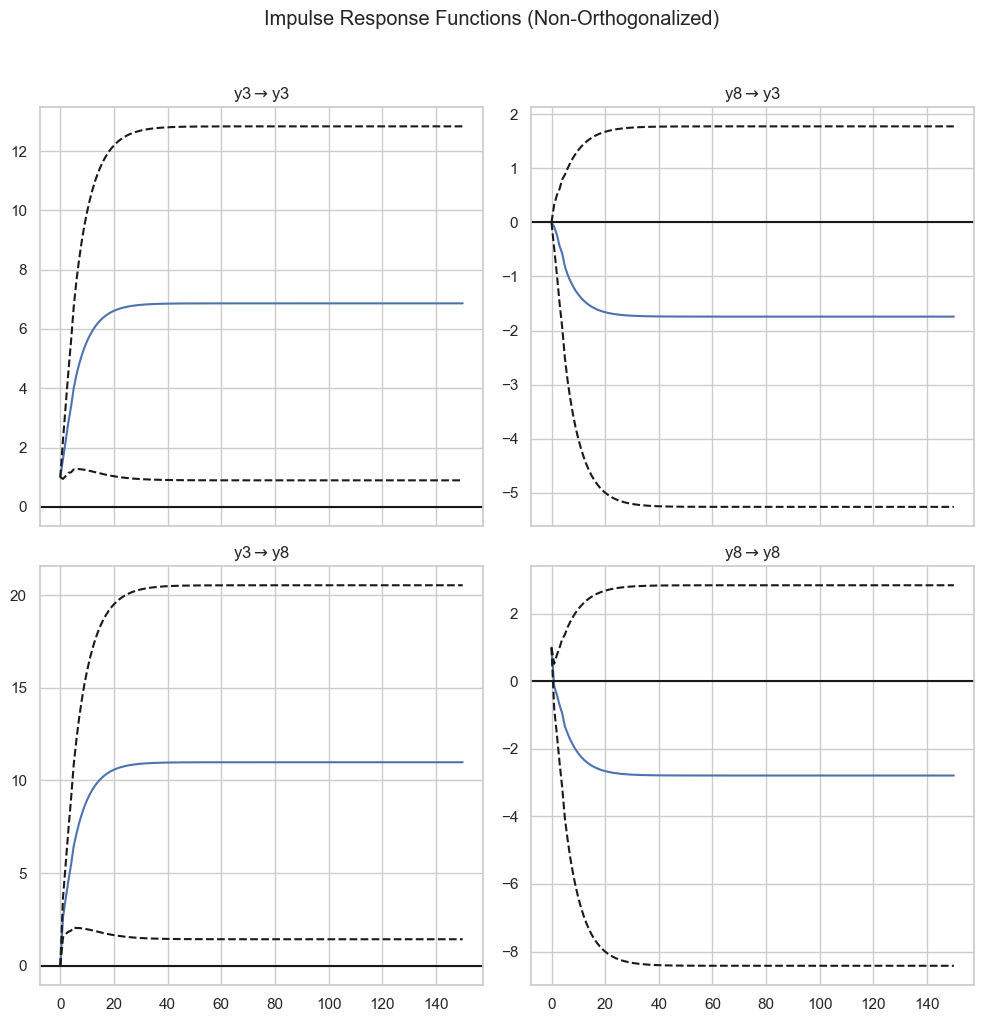

In [66]:
#Interpretation and evaluation
# Calculate and plot IRFs
irf = vecm_results.irf(periods=150) #150 periods ahead, for better visualization of shocks impact

# Non-orthogonalized IRFs
irf.plot(orth=False)
plt.suptitle('Impulse Response Functions (Non-Orthogonalized)', y=1.02)
plt.tight_layout()
plt.show()

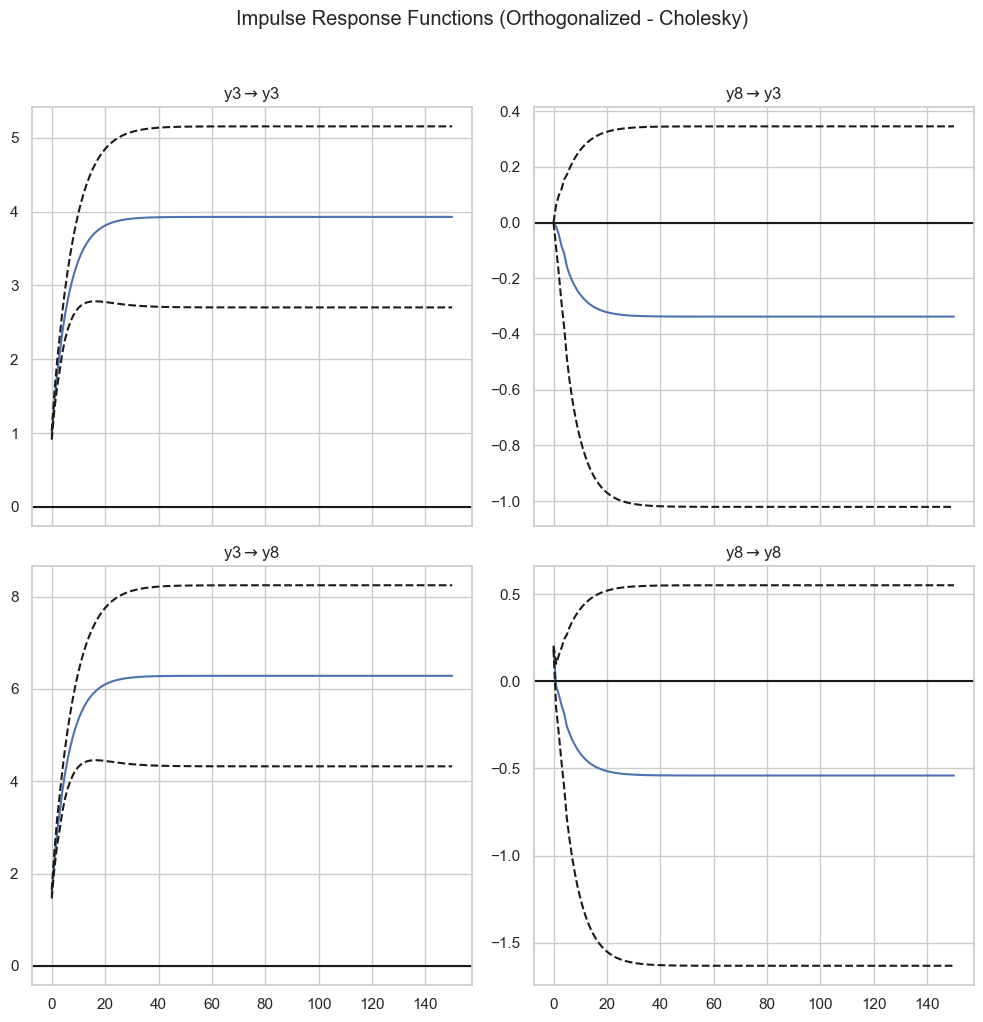

In [67]:
# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()

Interpretation

    y3->y3 : initial increase up to 25 days, and afterward slow decrease toward equilibrium
    y3->y8 : shock has bigger initial impact on y8, but as in previous case impacted variable is slowly converging toward 0
    y8->y3 : no first period impact of the y8 on y3. But we can observe negative impact on y3 and which converges back to 0
    y8->y8 : quick small jump at the beginning but as in previous case we are observing negative impact on first periods and convergence starting prior 25 period.

In [69]:
# Estimate VAR
var_model = VAR(data_for_test)
var_results = var_model.fit(5)

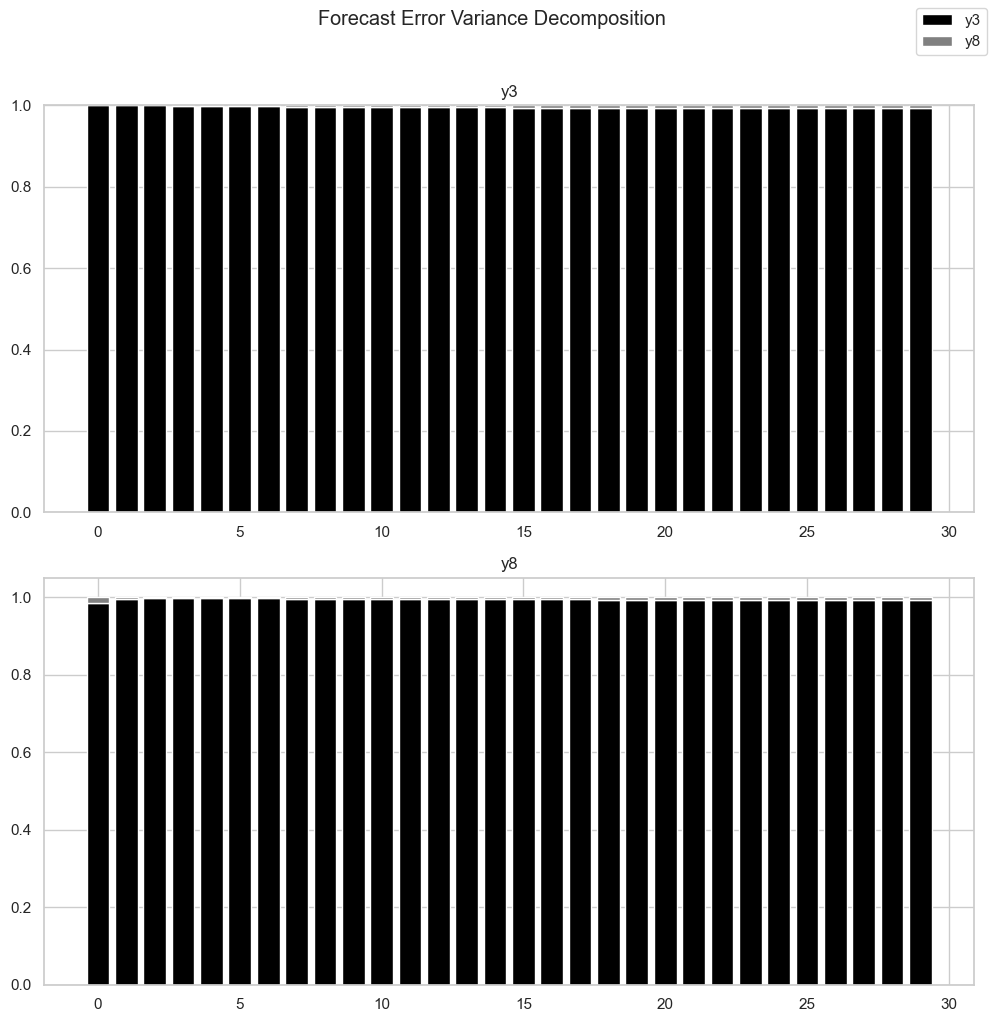


FEVD Summary (Period 30):
FEVD for y3
            y3        y8
0     1.000000  0.000000
1     0.999923  0.000077
2     0.999643  0.000357
3     0.999103  0.000897
4     0.998633  0.001367
5     0.997933  0.002067
6     0.997312  0.002688
7     0.996785  0.003215
8     0.996344  0.003656
9     0.995965  0.004035
10    0.995644  0.004356
11    0.995365  0.004635
12    0.995123  0.004877
13    0.994911  0.005089
14    0.994724  0.005276
15    0.994558  0.005442
16    0.994412  0.005588
17    0.994281  0.005719
18    0.994164  0.005836
19    0.994059  0.005941
20    0.993964  0.006036
21    0.993879  0.006121
22    0.993801  0.006199
23    0.993730  0.006270
24    0.993666  0.006334
25    0.993607  0.006393
26    0.993553  0.006447
27    0.993504  0.006496
28    0.993458  0.006542
29    0.993416  0.006584

FEVD for y8
            y3        y8
0     0.984604  0.015396
1     0.995009  0.004991
2     0.997225  0.002775
3     0.997661  0.002339
4     0.997640  0.002360
5     0.997178  0.00282

In [70]:
# Calculate and plot FEVD
fevd = var_results.fevd(periods=30) 
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
print("\nFEVD Summary (Period 30):")
print(fevd.summary())

In [71]:
residuals = vecm_results.resid
# to DataFrame
residuals = pd.DataFrame(residuals, columns=['y3', 'y8'], index=df.index[5:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals:")
ljung_box_y8 = acorr_ljungbox(residuals['y8'], lags=[5,10,15,20], return_df=True)
ljung_box_y3 = acorr_ljungbox(residuals['y3'], lags=[5,10,15,20], return_df=True)
print("\ny8 Residuals:\n", ljung_box_y8)
print("\ny3 Residuals:\n", ljung_box_y3)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_y8['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y8 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y8 residuals.")
if ljung_box_y3['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y3 residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y3 residuals.")

Residuals (first 5 rows):
                      y3            y8
date                                  
2023-09-14 -1.0597422347 -2.0089833968
2023-09-15 -0.8904504007 -1.2000212456
2023-09-16 -0.1786331779 -0.2323526760
2023-09-17  0.6779125796  0.9693181159
2023-09-18 -0.3187428485 -0.3086562064

Ljung-Box Test for Serial Correlation in Residuals:

y8 Residuals:
          lb_stat    lb_pvalue
5   1.0394042393 0.9593253466
10  7.4171412648 0.6855640975
15 10.3252413891 0.7987979760
20 16.4185595499 0.6903416518

y3 Residuals:
          lb_stat    lb_pvalue
5   0.8105597745 0.9763549240
10  7.0009853942 0.7253519228
15 11.3295182285 0.7289048283
20 17.6170731479 0.6126173317

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for y8 residuals.
 - Cannot reject H0 (no serial correlation) for y3 residuals.


## Forecasting with VECM model

In [72]:
# Create shorter sample (excluding last 25 observations)
df_short = df[['y3', 'y8']]
df_actual = df_oos[['y3', 'y8']]
print("Last few rows of shorter sample:")
print(df_short.tail())
print("\nActual values for forecast period:")
print(df_actual.head())

Last few rows of shorter sample:
                      y3            y8
date                                  
2025-04-01 82.2000000000 60.9000000000
2025-04-02 82.1600000000 61.0000000000
2025-04-03 81.6600000000 60.1900000000
2025-04-04 82.2800000000 60.6200000000
2025-04-05 82.9000000000 61.6800000000

Actual values for forecast period:
                      y3            y8
date                                  
2025-04-06 82.2000000000 61.1300000000
2025-04-07 82.6900000000 61.6000000000
2025-04-08 81.5900000000 59.9200000000
2025-04-09 81.1900000000 59.1000000000
2025-04-10 81.3900000000 59.4700000000


In [73]:
# Re-run Johansen test on shorter sample
johansen_result_short = coint_johansen(df_short, det_order=0, k_ar_diff=4)

print("\nJohansen Test on Shorter Sample (Trace Statistic):")
print("Trace Statistic:", johansen_result_short.lr1)
print("Critical Values (95%):", johansen_result_short.cvt[:, 1])

# Determine rank based on test
rank_short = 0
for i in range(len(johansen_result_short.lr1)):
    if johansen_result_short.lr1[i] > johansen_result_short.cvt[i, 1]:
        rank_short = i + 1
    else:
        break
print(f"--> Determined Cointegration Rank on shorter sample: r = {rank_short}")

# Assuming rank is still 1 based on R output/consistency, proceed with r=1
rank_short = 1 # Override if necessary based on re-evaluation
print(f"Proceeding with rank r = {rank_short} for forecasting model.")


Johansen Test on Shorter Sample (Trace Statistic):
Trace Statistic: [119.99746771   1.22229641]
Critical Values (95%): [15.4943  3.8415]
--> Determined Cointegration Rank on shorter sample: r = 1
Proceeding with rank r = 1 for forecasting model.


In [74]:
# Re-estimate VECM on shorter sample
vecm_model_short = VECM(df_short, k_ar_diff=4, coint_rank=rank_short, deterministic='ci')
vecm_results_short = vecm_model_short.fit()

# Generate forecasts
forecast_values = vecm_results_short.predict(steps=forecast_horizon)
forecast_intervals = vecm_results_short.predict(steps=forecast_horizon, alpha=0.05) # alpha=0.05 for 95% CI

# Create forecast DataFrame
forecast_index = df_actual.index
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['y3_fore', 'y8_fore'])

In [75]:
print(forecast_df)

                 y3_fore       y8_fore
date                                  
2025-04-06 83.2953517681 62.6581555533
2025-04-07 83.6206148183 63.1527464818
2025-04-08 83.9358086698 63.6556481095
2025-04-09 84.2580262758 64.1887629686
2025-04-10 84.5462724140 64.6391044443
2025-04-11 84.7656582392 64.9793357403
2025-04-12 84.9499816636 65.2745389852
2025-04-13 85.1086898768 65.5274843377
2025-04-14 85.2429560518 65.7424181123
2025-04-15 85.3562346082 65.9244501770
2025-04-16 85.4532793735 66.0799714295
2025-04-17 85.5360293699 66.2123189764
2025-04-18 85.6065261517 66.3251315083
2025-04-19 85.6664900881 66.4210156427
2025-04-20 85.7174776000 66.5025365722
2025-04-21 85.7608257299 66.5718674042
2025-04-22 85.7977014139 66.6308549642
2025-04-23 85.8290645880 66.6810243032
2025-04-24 85.8557436620 66.7237036428
2025-04-25 85.8784402774 66.7600112136
2025-04-26 85.8977489748 66.7908981764
2025-04-27 85.9141742973 66.8171725044
2025-04-28 85.9281468856 66.8395232952
2025-04-29 85.9400328040 

In [76]:
# Create forecast interval DataFrames
forecast_lower = pd.DataFrame(forecast_intervals[1], index=forecast_index, columns=['y3_lower', 'y8_lower'])
forecast_upper = pd.DataFrame(forecast_intervals[2], index=forecast_index, columns=['y3_upper', 'y8_upper'])

# Combine forecasts and intervals
forecast_combined = pd.concat([forecast_df, forecast_lower, forecast_upper], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_combined)


Forecasts and Confidence Intervals:
                 y3_fore       y8_fore      y3_lower      y8_lower       y3_upper       y8_upper
date                                                                                            
2025-04-06 83.2953517681 62.6581555533 81.4016285097 59.5930207579  85.1890750265  65.7232903486
2025-04-07 83.6206148183 63.1527464818 80.2373224848 57.7107715394  87.0039071518  68.5947214243
2025-04-08 83.9358086698 63.6556481095 79.0582116418 55.8037679070  88.8134056978  71.5075283119
2025-04-09 84.2580262758 64.1887629686 77.8973562822 53.9796470052  90.6186962694  74.3978789321
2025-04-10 84.5462724140 64.6391044443 76.6657772534 52.0056920475  92.4267675746  77.2725168411
2025-04-11 84.7656582392 64.9793357403 75.3702977097 49.9251508230  94.1610187688  80.0335206576
2025-04-12 84.9499816636 65.2745389852 74.0597940725 47.8305206441  95.8401692548  82.7185573263
2025-04-13 85.1086898768 65.5274843377 72.7551258952 45.7441659096  97.4622538585  85.3108

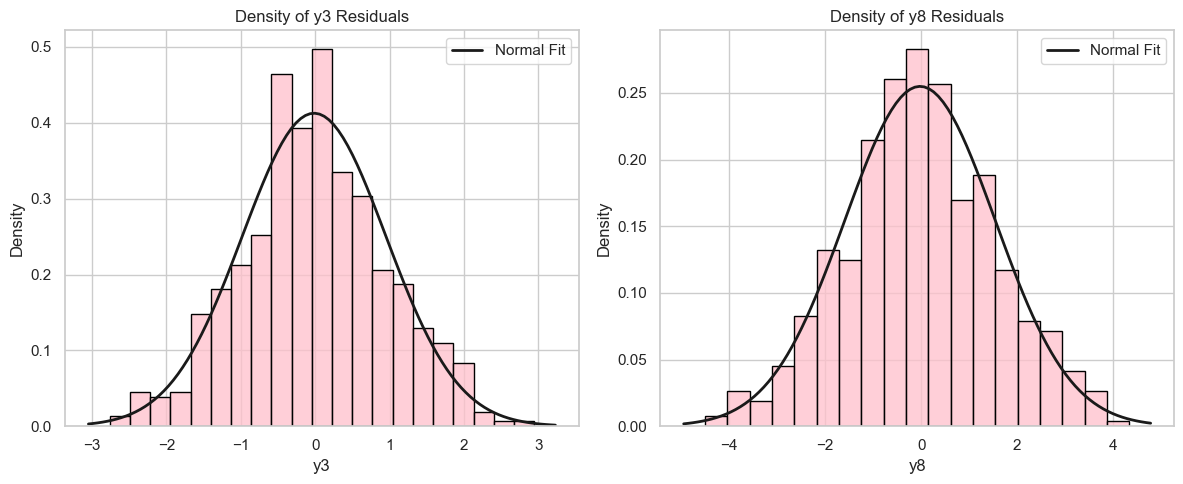

In [77]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['y3'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of y3 Residuals')
# Overlay normal distribution
mu_y3, std_y3 = residuals['y3'].mean(), residuals['y3'].std()
xmin_y3, xmax_y3 = axes[0].get_xlim()
x_y3 = np.linspace(xmin_y3, xmax_y3, 100)
p_y3 = norm.pdf(x_y3, mu_y3, std_y3)
axes[0].plot(x_y3, p_y3, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y8'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y8 Residuals')
# Overlay normal distribution
mu_y8, std_y8 = residuals['y8'].mean(), residuals['y8'].std()
xmin_y8, xmax_y8 = axes[1].get_xlim()
x_y8 = np.linspace(xmin_y8, xmax_y8, 100)
p_y8 = norm.pdf(x_y8, mu_y8, std_y8)
axes[1].plot(x_y8, p_y8, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

In [78]:
# Test for normality (Jarque-Bera test)
jb_y3_stat, jb_y3_pval, _, _ = jarque_bera(residuals['y3'])
jb_y8_stat, jb_y8_pval, _, _ = jarque_bera(residuals['y8'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"y3 Residuals: Statistic={jb_y3_stat:.3f}, p-value={jb_y3_pval:.3f}")
print(f"y8 Residuals: Statistic={jb_y8_stat:.3f}, p-value={jb_y8_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_y3_pval < alpha_norm:
    print(" - Reject normality for y3 residuals.")
else:
    print(" - Cannot reject normality for y3 residuals.")
if jb_y8_pval < alpha_norm:
    print(" - Reject normality for y8 residuals.")
else:
    print(" - Cannot reject normality for y8 residuals.")

# Multivariate Normality Test (using VECM Results method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECM Results method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")


Jarque-Bera Normality Test for Residuals:
y3 Residuals: Statistic=0.188, p-value=0.910
y8 Residuals: Statistic=0.613, p-value=0.736

Conclusion at alpha=0.05:
 - Cannot reject normality for y3 residuals.
 - Cannot reject normality for y8 residuals.

Multivariate Normality Test Results (using VECM Results method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 0.985, critical value: 9.488>, p-value: 0.912>


Result: basing on a graph and on Jarque-Bera test we can conclude that residuals come from standard normal distribution.

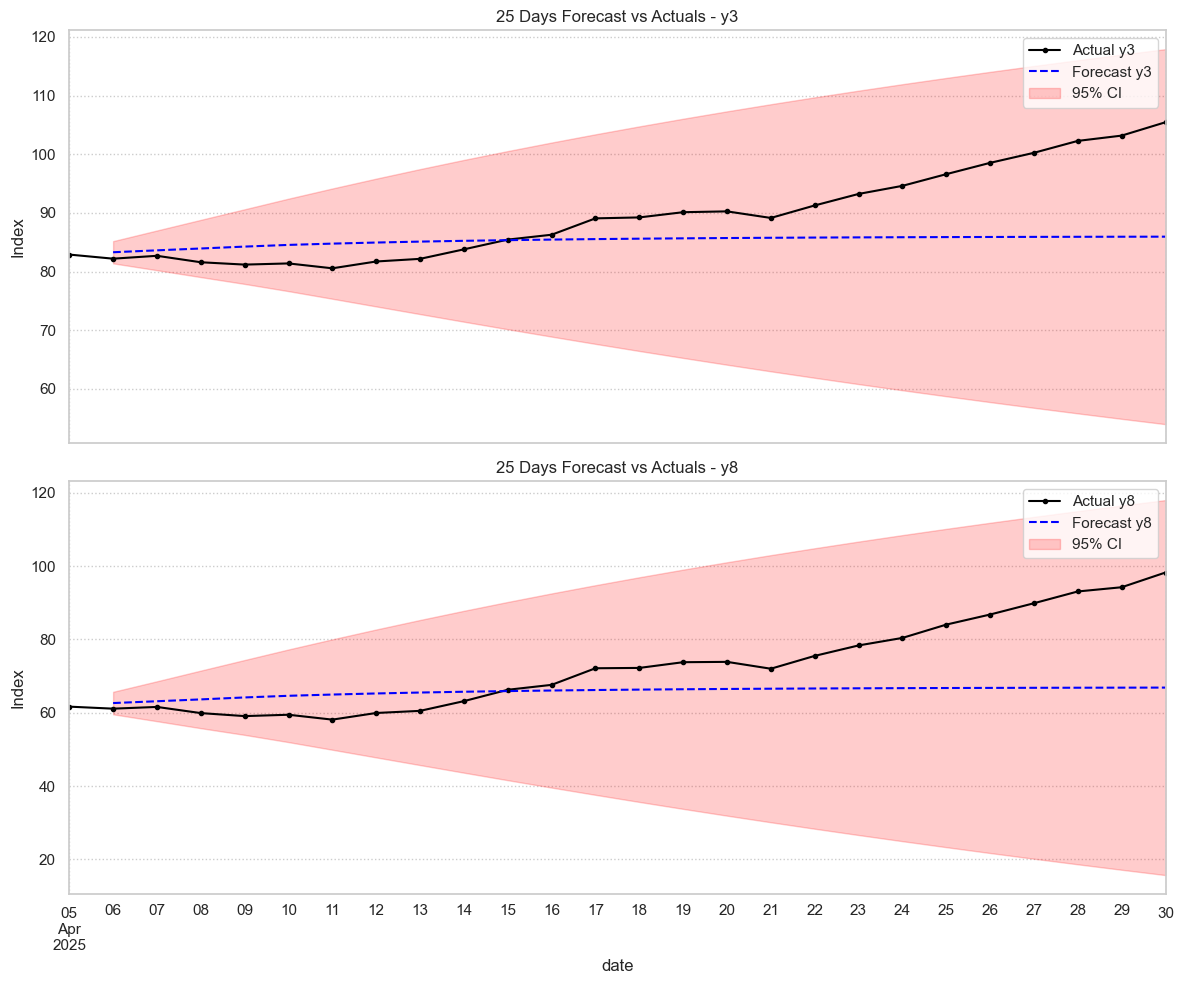

In [79]:
# Merge forecasts with the original data for plotting
df_merged = df1.merge(forecast_combined, left_index=True, right_index=True, how='left') #we merge to "full" df1 set

# Plot forecasts vs actuals
plot_start_date = '2025-04-05' # Start date for the plot window

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# y3 Plot
df_merged.loc[plot_start_date:, 'y3'].plot(ax=axes[0], label='Actual y3', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y3_fore'].plot(ax=axes[0], label='Forecast y3', color='blue', linestyle='--')
axes[0].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'y3_lower'],
                     df_merged.loc[plot_start_date:, 'y3_upper'], color='red', alpha=0.2, label='95% CI')
axes[0].set_title('25 Days Forecast vs Actuals - y3')
axes[0].set_ylabel('Index')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# y5 Plot
df_merged.loc[plot_start_date:, 'y8'].plot(ax=axes[1], label='Actual y8', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y8_fore'].plot(ax=axes[1], label='Forecast y8', color='blue', linestyle='--')
axes[1].fill_between(df_merged.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'y8_lower'],
                     df_merged.loc[plot_start_date:, 'y8_upper'], color='red', alpha=0.2, label='95% CI')
axes[1].set_title('25 Days Forecast vs Actuals - y8')
axes[1].set_ylabel('Index')
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

In [80]:
# Generate confidence intervals using the forecast error covariance
# This is a simplification as statsmodels doesn't directly provide confidence intervals
def compute_forecast_ci(model_results, y_values, steps, alpha=0.05):
    """Compute confidence intervals for VAR forecasts"""
    forecast_mean = model_results.forecast(y_values, steps)
    
    # Get forecast error covariance matrix for h-step ahead forecasts
    mse = np.zeros((steps, model_results.neqs, model_results.neqs))
    for i in range(steps):
        mse[i] = model_results.forecast_cov(i+1)[-1] #do zmiany !!!
    
    # Compute standard errors for each forecast
    stderr = np.zeros((steps, model_results.neqs))
    for i in range(steps):
        stderr[i] = np.sqrt(np.diag(mse[i]))
    
    # Compute confidence intervals
    from scipy.stats import norm
    q = norm.ppf(1 - alpha/2)
    lower = forecast_mean - q * stderr
    upper = forecast_mean + q * stderr
    
    return forecast_mean, lower, upper

# Full set without differences
df1_no_diff=df1[['y3', 'y8']]

# Calculate forecast means and 95% confidence intervals
forecast_mean, forecast_lower, forecast_upper = compute_forecast_ci(
    var_results, df_short.values, forecast_horizon, alpha=0.05
)

# Create DataFrames for the confidence intervals
forecast_lower_df = pd.DataFrame(forecast_lower, index=forecast_index, 
                               columns=[f"{col}_lower" for col in df_short.columns])
forecast_upper_df = pd.DataFrame(forecast_upper, index=forecast_index, 
                               columns=[f"{col}_upper" for col in df_short.columns])

# Combine the forecasts and actual values
forecast_evaluation = pd.concat([
    df1_no_diff.loc[forecast_index],
    forecast_df,
    forecast_lower_df,
    forecast_upper_df
], axis=1)

forecast_evaluation.columns = [
    'y3_actual', 'y8_actual', 
    'y3_forecast', 'y8_forecast',
    'y3_lower', 'y8_lower',
    'y3_upper', 'y8_upper'
]

print("Forecast evaluation dataset:")
print(forecast_evaluation)

Forecast evaluation dataset:
                y3_actual     y8_actual   y3_forecast   y8_forecast      y3_lower      y8_lower       y3_upper       y8_upper
date                                                                                                                         
2025-04-06  82.2000000000 61.1300000000 83.2953517681 62.6581555533 81.4212707446 59.6236119452  85.2412731314  65.8068425353
2025-04-07  82.6900000000 61.6000000000 83.6206148183 63.1527464818 80.3009958782 57.8120858861  87.1190407751  68.7791193876
2025-04-08  81.5900000000 59.9200000000 83.9358086698 63.6556481095 79.1841063125 56.0052303272  89.0049509458  71.8150383454
2025-04-09  81.1900000000 59.1000000000 84.2580262758 64.1887629686 78.0981254818 54.3009788568  90.8956310758  74.8417367157
2025-04-10  81.3900000000 59.4700000000 84.5462724140 64.6391044443 76.9509024428 52.4621178329  92.7994648532  77.8695075099
2025-04-11  80.5600000000 58.1400000000 84.7656582392 64.9793357403 75.7494421245 50.5320

In [81]:
# Calculate forecast accuracy measures

# Define the function for MAPE and AMAPE
def mape(actual, pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / actual)) * 100

def amape(actual, pred):
    """Adjusted/Symmetric Mean Absolute Percentage Error"""
    return np.mean(np.abs((actual - pred) / ((actual + pred) / 2))) * 100

# Calculate metrics for y3
y3_mae = mean_absolute_error(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])
y3_mse = mean_squared_error(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])
y3_rmse = np.sqrt(y3_mse)
y3_mape = mape(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])
y3_amape = amape(forecast_evaluation['y3_actual'], forecast_evaluation['y3_forecast'])

# Calculate metrics for y8
y8_mae = mean_absolute_error(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])
y8_mse = mean_squared_error(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])
y8_rmse = np.sqrt(y8_mse)
y8_mape = mape(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])
y8_amape = amape(forecast_evaluation['y8_actual'], forecast_evaluation['y8_forecast'])

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'y3': [y3_mae, y3_mse, y3_rmse, y3_mape, y3_amape],
    'y8': [y8_mae, y8_mse, y8_rmse, y8_mape, y8_amape]
}, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'])

print("Forecast Accuracy Metrics:")
print(metrics_df)

Forecast Accuracy Metrics:
                     y3             y8
MAE        6.2102120111  10.0165787644
MSE       69.1717116420 177.9095428609
RMSE       8.3169532668  13.3382736087
MAPE (%)   6.5161987141  12.4200600164
AMAPE (%)  6.8520429087  13.5389324385


In [ ]:
#We can see that model that predicts "y3" values is more accurate comparing to model predicting "y8"

## ARIMA modelling

As we previously concluded, 'y3' and 'y8' variables are ~I(1) cointegrated processes. We will analyse what would the best suited model for prediction of returns on this variables!

In [82]:
# Split data
sample_df = df

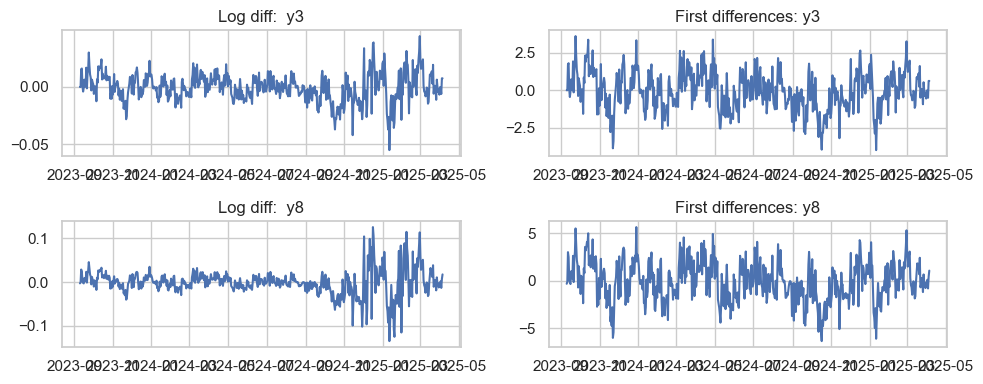

In [83]:
fig, axs = plt.subplots(2, 2, figsize = (10, 4))

axs[0, 0].plot(np.log(sample_df['y3']).diff().dropna())
axs[0, 0].set_title('Log diff:  y3')

axs[0, 1].plot(sample_df['dy3'])
axs[0, 1].set_title('First differences: y3')

axs[1, 0].plot(np.log(sample_df['y8']).diff().dropna())
axs[1, 0].set_title('Log diff:  y8')

axs[1, 1].plot(sample_df['dy8'])
axs[1, 1].set_title('First differences: y8')

plt.tight_layout()

We will now apply Box-Jenkins procedure to find p,d,q values for ARIMA(p, d, q). This procedure utilizes ACF and PACF to determine correspondingly right MA order and right AR model. We already have order of integration as we have shown that series are both non-stationary but their differences are stationary implying integration of order 1

#### ARIMA model for y3 variable

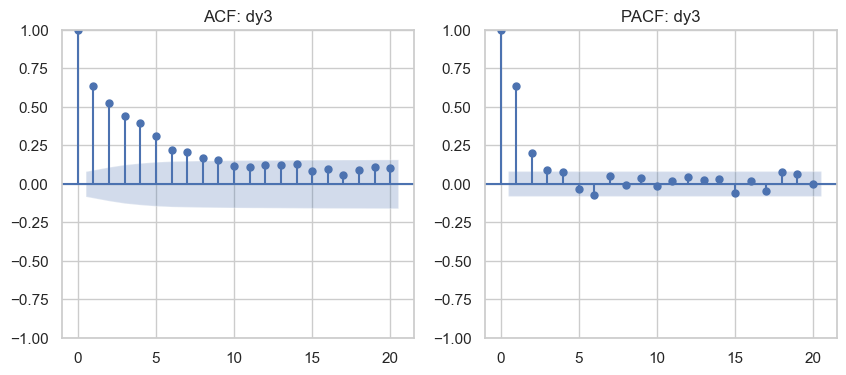

In [84]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(sample_df['y3'].diff().dropna(), lags=20, ax=axes[0])
axes[0].set_title("ACF: dy3")

plot_pacf(sample_df['y3'].diff().dropna(), lags=20, ax=axes[1]) 
axes[1].set_title("PACF: dy3")

plt.show()

We observe quite interesting behavior - for y3 variable, ACF is decaying exponentially, which would be expected for simple AR(2) models. PACF on the other hand oscilates around 0, but also the greatest spike, which at the same time is significantly greater than other spikes is the first two lags.There is a possibility that the right model will be just AR(2) for differenced series, so ARIMA(2,1,0), but one should also observe that 6th lag could be statistically significant for model prediction. For now, let's try ARIMA(2,1,0)!

In [85]:
model = ARIMA(df["y3"].values, order=([2], 1, 0))
arima_210_y3 = model.fit()
print(arima_210_y3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:               ARIMA([2], 1, 0)   Log Likelihood                -868.233
Date:                Thu, 03 Jul 2025   AIC                           1740.466
Time:                        12:53:19   BIC                           1749.171
Sample:                             0   HQIC                          1743.861
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.5213      0.035     15.038      0.000       0.453       0.589
sigma2         1.2047      0.074     16.226      0.000       1.059       1.350
Ljung-Box (L1) (Q):                  66.01   Jarque-

In [86]:
print("Ljung-Box Test for Residual Autocorrelation:")
ljung_test = acorr_ljungbox(arima_210_y3.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test) #no autocorrelation for each lag

Ljung-Box Test for Residual Autocorrelation:
        lb_stat    lb_pvalue
5  0.8119677315 0.9762637318
10 0.9877312986 0.9998373676
15 1.8301737787 0.9999835869
20 1.9711284503 0.9999999024
25 2.0583105491 0.9999999997


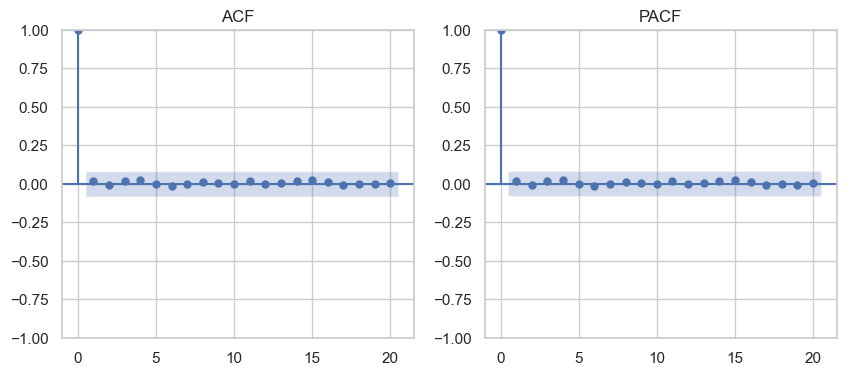

In [87]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_210_y3.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_210_y3.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

Model specification is correct. There is no autocorrelations in model residuals, and as usually we prefer simple models we could just take this one and move forward with the analysis as this model is basically the simplest one we can get. However, we can't really say that this model is certainly the best one without some comparison. It is therefore useful to study also different model specifications and compare them on information criteria basis (lower is better).

#### ARIMA model for y8 variable

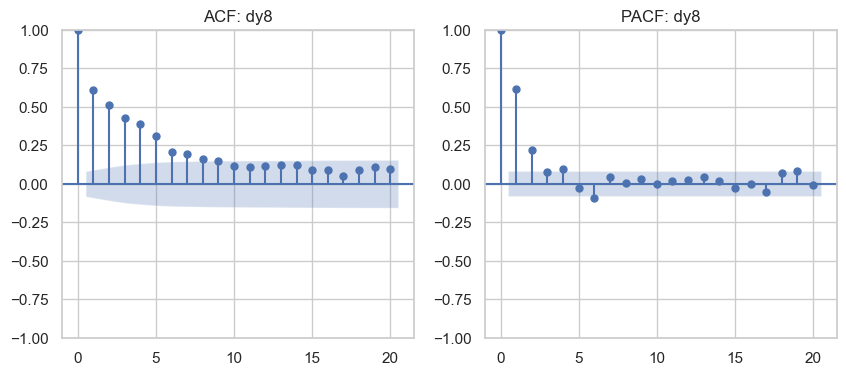

In [88]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(sample_df['y8'].diff().dropna(), lags=20, ax=axes[0])
axes[0].set_title("ACF: dy8")

plot_pacf(sample_df['y8'].diff().dropna(), lags=20, ax=axes[1]) 
axes[1].set_title("PACF: dy8")

plt.show()

We observe quite interesting behavior - for y8 variable, ACF is decaying exponentially, which would be expected for simple AR(2) models. PACF on the other hand oscilates around 0, but also the greatest spike, which at the same time is significantly greater than other spikes is the first two lags.There is a possibility that the right model will be just AR(2) for differenced series, so ARIMA(2,1,0), but one should also observe that 6th lag could be statistically significant for model prediction. For now, let's try ARIMA(2,1,0)!

In [89]:
model = ARIMA(df["y8"].values, order=([2], 1, 0))
arima_210_y8 = model.fit()
print(arima_210_y8.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:               ARIMA([2], 1, 0)   Log Likelihood               -1148.805
Date:                Thu, 03 Jul 2025   AIC                           2301.611
Time:                        12:53:42   BIC                           2310.316
Sample:                             0   HQIC                          2305.006
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.5115      0.035     14.778      0.000       0.444       0.579
sigma2         3.2023      0.197     16.235      0.000       2.816       3.589
Ljung-Box (L1) (Q):                  62.24   Jarque-

In [90]:
print("Ljung-Box Test for Residual Autocorrelation:")
ljung_test = acorr_ljungbox(arima_210_y8.resid, lags=[5, 10, 15, 20, 25], return_df=True)
print(ljung_test)

Ljung-Box Test for Residual Autocorrelation:
        lb_stat    lb_pvalue
5  3.3508856262 0.6460605790
10 3.7183441239 0.9591597938
15 5.8681659083 0.9818781024
20 6.3037660221 0.9984201650
25 6.4730838352 0.9999286190


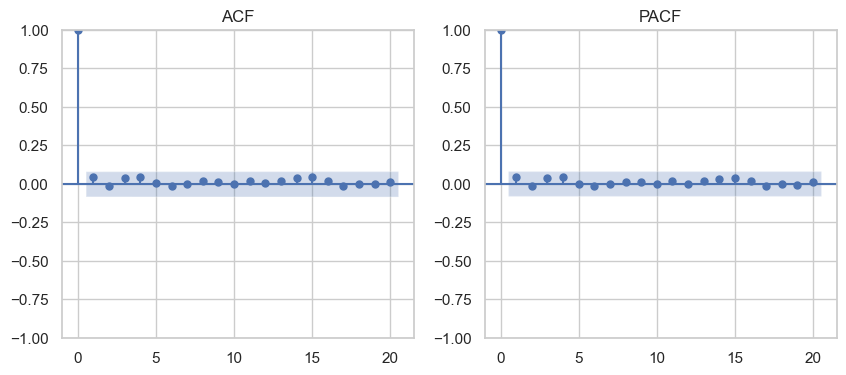

In [91]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

plot_acf(arima_210_y8.resid, lags=20, ax=axes[0]) 
axes[0].set_title("ACF")

plot_pacf(arima_210_y8.resid, lags=20, ax=axes[1]) 
axes[1].set_title("PACF")

plt.show()

Model specification is correct. There is no autocorrelations in model residuals, and as usually we prefer simple models we could just take this one and move forward with the analysis as this model is basically the simplest one we can get. However, we can't really say that this model is certainly the best one without some comparison. It is therefore useful to study also different model specifications and compare them on information criteria basis (lower is better).

## Forecasting with ARIMA models

In [92]:
# Create shorter sample (excluding last 25 observations)
df_short = df

df_actual = df_oos

In [93]:
#Forecast ARIMA(2,1,0) for y3
# Re-estimate VECM on shorter sample
model_1 = ARIMA(df_short["y3"].values, order=([2], 1, 0))
arima_210_y3_short = model_1.fit()

# Forecast for next 25 observations 
forecast_results_y3 = arima_210_y3_short.get_forecast(steps=25)

# Point forecast
forecast_values_y3 = forecast_results_y3.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals_y3 = forecast_results_y3.conf_int()

forecast_df_y3 = pd.DataFrame({
    "y3_fore": forecast_values_y3,
    "y3_lower": confidence_intervals_y3[:, 0],
    "y3_upper": confidence_intervals_y3[:, 1],
    "y3_actual": df_oos['y3']
}, index=df_oos.index)

forecast_df_y3

,y3_fore,y3_lower,y3_upper,y3_actual
date,,,,
2025-04-06,83.2232181537,81.0720077338,85.3744285736,82.2000000000
2025-04-07,83.5464363074,80.5041653561,86.5887072588,82.6900000000
2025-04-08,83.7149362670,79.2466214124,88.1832511215,81.5900000000
2025-04-09,83.8834362265,78.3448206290,89.4220518239,81.1900000000
2025-04-10,83.9712785584,77.2218196827,90.7207374342,81.3900000000
2025-04-11,84.0591208904,76.2851818956,91.8330598852,80.5600000000
2025-04-12,84.1049148200,75.2869065368,92.9229231032,81.7200000000
2025-04-13,84.1507087496,74.3997901945,93.9016273047,82.1700000000
2025-04-14,84.1745820228,73.5091498226,94.8400142230,83.7900000000


In [94]:
#Forecast ARIMA(2,1,0) for y8
# Re-estimate VECM on shorter sample
model_2 = ARIMA(df_short["y8"].values, order=([2], 1, 0))
arima_210_y8_short = model_2.fit()

# Forecast for next 25 observations 
forecast_results_y8 = arima_210_y8_short.get_forecast(steps=25)

# Point forecast
forecast_values_y8 = forecast_results_y8.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
confidence_intervals_y8 = forecast_results_y8.conf_int()

forecast_df_y8 = pd.DataFrame({
    "y8_fore": forecast_values_y8,
    "y8_lower": confidence_intervals_y8[:, 0],
    "y8_upper": confidence_intervals_y8[:, 1],
    "y8_actual": df_oos['y8']
}, index=df_oos.index)

forecast_df_y8

,y8_fore,y8_lower,y8_upper,y8_actual
date,,,,
2025-04-06,61.8999452963,58.3926125791,65.4072780135,61.1300000000
2025-04-07,62.4421360268,57.4820185304,67.4022535232,61.6000000000
2025-04-08,62.5546381975,55.2946845444,69.8145918506,59.9200000000
2025-04-09,62.8319691298,53.8424703389,71.8214679207,59.1000000000
2025-04-10,62.8895140676,51.9585181422,73.8205099930,59.4700000000
2025-04-11,63.0313690306,50.4551114263,75.6076266349,58.1400000000
2025-04-12,63.0608033059,48.8166414510,77.3049651609,59.9500000000
2025-04-13,63.1333622173,47.3970971405,78.8696272941,60.5300000000
2025-04-14,63.1484178694,45.9544338362,80.3424019026,63.1800000000


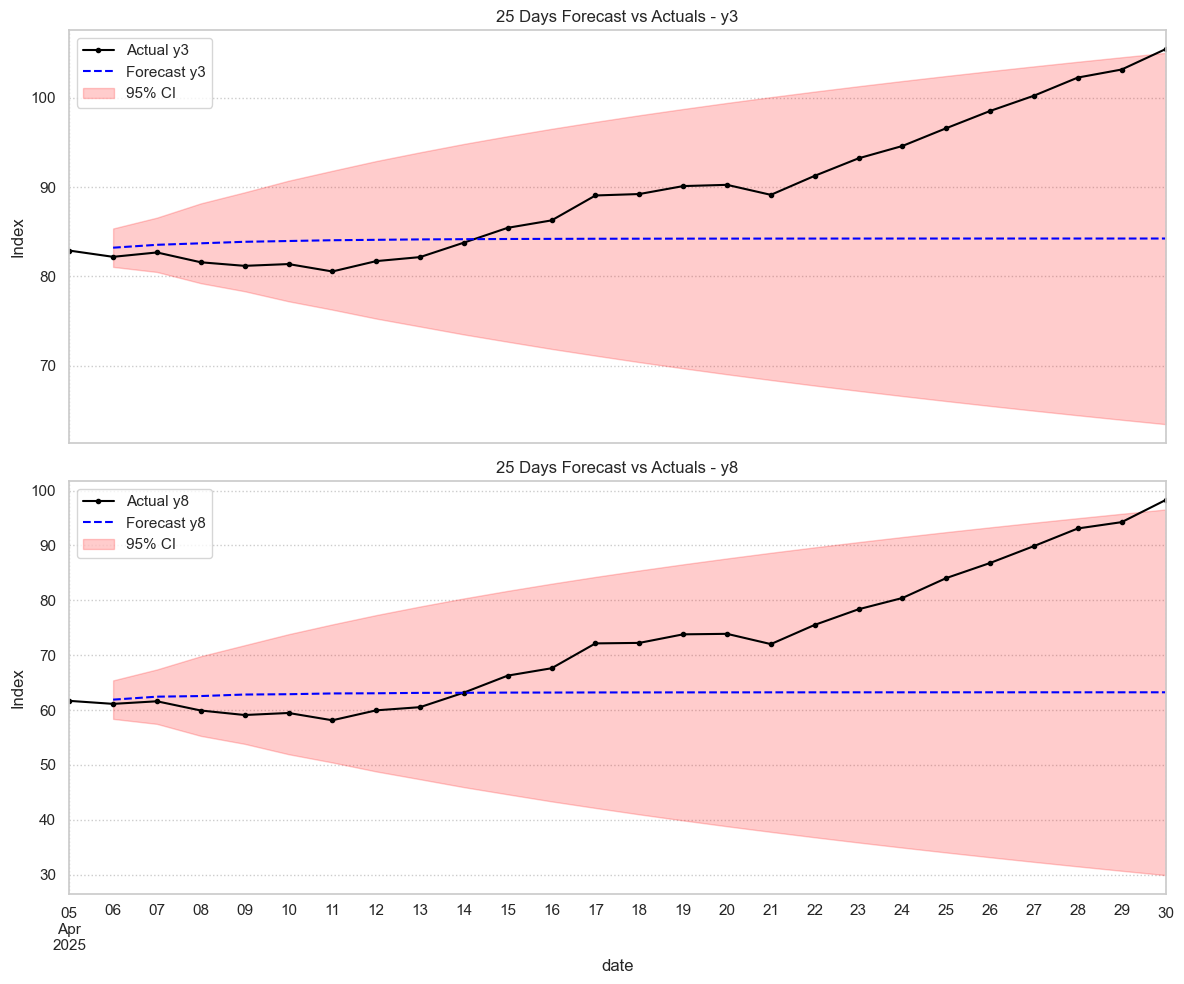

In [96]:
# Merge forecasts with the original data for plotting
df_merged_y3 = df1.merge(forecast_df_y3, left_index=True, right_index=True, how='left') #we merge to "full" df1 set
df_merged_y8 = df1.merge(forecast_df_y8, left_index=True, right_index=True, how='left') #we merge to "full" df1 set

# Plot forecasts vs actuals
plot_start_date = '2025-04-05' # Start date for the plot window

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# y3 Plot
df_merged_y3.loc[plot_start_date:, 'y3'].plot(ax=axes[0], label='Actual y3', color='black', marker='.')
df_merged_y3.loc[plot_start_date:, 'y3_fore'].plot(ax=axes[0], label='Forecast y3', color='blue', linestyle='--')
axes[0].fill_between(df_merged_y3.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged_y3.loc[plot_start_date:, 'y3_lower'],
                     df_merged_y3.loc[plot_start_date:, 'y3_upper'], color='red', alpha=0.2, label='95% CI')
axes[0].set_title('25 Days Forecast vs Actuals - y3')
axes[0].set_ylabel('Index')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# y8 Plot
df_merged_y8.loc[plot_start_date:, 'y8'].plot(ax=axes[1], label='Actual y8', color='black', marker='.')
df_merged_y8.loc[plot_start_date:, 'y8_fore'].plot(ax=axes[1], label='Forecast y8', color='blue', linestyle='--')
axes[1].fill_between(df_merged_y8.loc[plot_start_date:].index, # Ensure index alignment
                     df_merged_y8.loc[plot_start_date:, 'y8_lower'],
                     df_merged_y8.loc[plot_start_date:, 'y8_upper'], color='red', alpha=0.2, label='95% CI')
axes[1].set_title('25 Days Forecast vs Actuals - y8')
axes[1].set_ylabel('Index')
axes[1].legend()
axes[1].grid(True, linestyle=':')


plt.tight_layout()
plt.show()

In [97]:
# Forecast evaluation: ARIMA(2,1,0) for y3
mape_y3 = mape(df1['y3'][-25:], forecast_df_y3['y3_fore'])
amape_y3 = amape(df1['y3'][-25:], forecast_df_y3['y3_fore'])
mse_y3 = mean_squared_error(df1['y3'][-25:], forecast_df_y3['y3_fore'])
mae_y3 = mean_absolute_error(df['y3'][-25:], forecast_df_y3['y3_fore'])
rmse_y3 = np.sqrt(mse_y3)

# Forecast evaluation: ARIMA(2,1,0) for y8
mape_y8 = mape(df1['y8'][-25:], forecast_df_y8['y8_fore'])
amape_y8 = amape(df1['y8'][-25:], forecast_df_y8['y8_fore'])
mse_y8 = mean_squared_error(df1['y8'][-25:], forecast_df_y8['y8_fore'])
mae_y8 = mean_absolute_error(df['y8'][-25:], forecast_df_y8['y8_fore'])
rmse_y8 = np.sqrt(mse_y8)

comparison_df = pd.DataFrame({
    'Metric': ['MAPE', 'AMAPE', 'MSE', 'RMSE', 'MAE'],
    'ARIMA for y3:': [mape_y3, amape_y3, mse_y3, rmse_y3, mae_y3],
    'ARIMA for y8:': [mape_y8, amape_y8, mse_y8, rmse_y8, mae_y8]
})

print(comparison_df)

  Metric  ARIMA for y3:  ARIMA for y8:
0   MAPE   7.3074806140  14.1275407314
1  AMAPE   7.7580497038  15.8588173567
2    MSE  86.9272261901 240.7671751828
3   RMSE   9.3234771513  15.5166741018
4    MAE   1.9867512491   2.4830479443


## Final comparison: VECM vs ARIMA

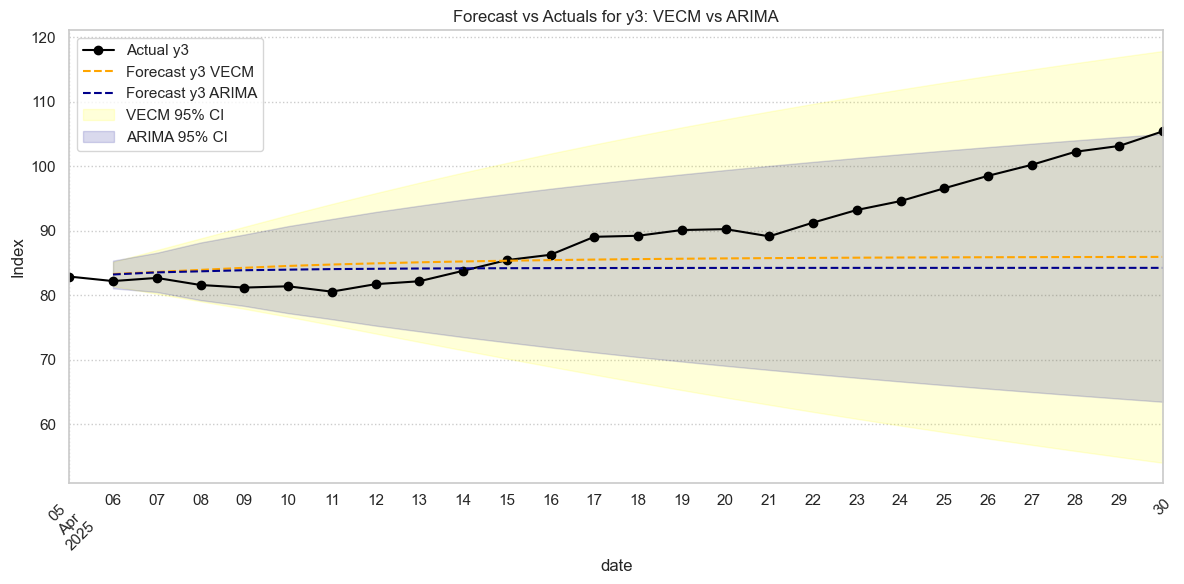

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actuals
df_merged.loc[plot_start_date:, 'y3'].plot(ax=ax, label='Actual y3', color='black', marker='o')

# Forecasts
df_merged.loc[plot_start_date:, 'y3_fore'].plot(ax=ax, label='Forecast y3 VECM', color='orange', linestyle='--')
df_merged_y3.loc[plot_start_date:, 'y3_fore'].plot(ax=ax, label='Forecast y3 ARIMA', color='darkblue', linestyle='--')

# Confidence intervals
ax.fill_between(df_merged.loc[plot_start_date:].index,
                df_merged.loc[plot_start_date:, 'y3_lower'],
                df_merged.loc[plot_start_date:, 'y3_upper'], color='yellow', alpha=0.15, label='VECM 95% CI')

ax.fill_between(df_merged_y3.loc[plot_start_date:].index,
                df_merged_y3.loc[plot_start_date:, 'y3_lower'],
                df_merged_y3.loc[plot_start_date:, 'y3_upper'], color='darkblue', alpha=0.15, label='ARIMA 95% CI')

ax.set_title('Forecast vs Actuals for y3: VECM vs ARIMA')
ax.set_ylabel('Index')
ax.legend()
ax.grid(True, linestyle=':')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

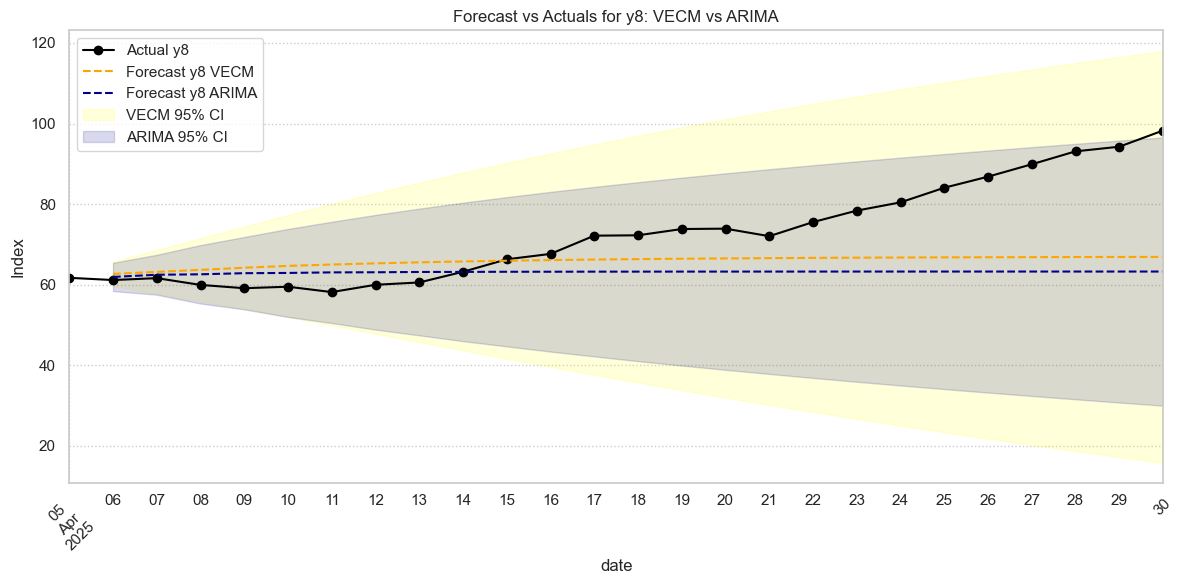

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actuals
df_merged.loc[plot_start_date:, 'y8'].plot(ax=ax, label='Actual y8', color='black', marker='o')

# Forecasts
df_merged.loc[plot_start_date:, 'y8_fore'].plot(ax=ax, label='Forecast y8 VECM', color='orange', linestyle='--')
df_merged_y8.loc[plot_start_date:, 'y8_fore'].plot(ax=ax, label='Forecast y8 ARIMA', color='darkblue', linestyle='--')

# Confidence intervals
ax.fill_between(df_merged.loc[plot_start_date:].index,
                df_merged.loc[plot_start_date:, 'y8_lower'],
                df_merged.loc[plot_start_date:, 'y8_upper'], color='yellow', alpha=0.15, label='VECM 95% CI')

ax.fill_between(df_merged_y8.loc[plot_start_date:].index,
                df_merged_y8.loc[plot_start_date:, 'y8_lower'],
                df_merged_y8.loc[plot_start_date:, 'y8_upper'], color='darkblue', alpha=0.15, label='ARIMA 95% CI')

ax.set_title('Forecast vs Actuals for y8: VECM vs ARIMA')
ax.set_ylabel('Index')
ax.legend()
ax.grid(True, linestyle=':')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [100]:
#Evaluation metrics (sorting would be beneficial)
combined_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'AMAPE (%)'],
    'ARIMA_y3': [mae_y3, mse_y3, rmse_y3, mape_y3, amape_y3],
    'VECM_y3': [y3_mae, y3_mse, y3_rmse, y3_mape, y3_amape],
    'ARIMA_y8': [mae_y8, mse_y8, rmse_y8, mape_y8, amape_y8],
    'VECM_y8': [y8_mae, y8_mse, y8_rmse, y8_mape, y8_amape]
})

# Optional: round for cleaner output
combined_df = combined_df.round(4)

print("Combined Forecast Accuracy Metrics:")
print(combined_df)

Combined Forecast Accuracy Metrics:
      Metric      ARIMA_y3       VECM_y3       ARIMA_y8        VECM_y8
0        MAE  1.9868000000  6.2102000000   2.4830000000  10.0166000000
1        MSE 86.9272000000 69.1717000000 240.7672000000 177.9095000000
2       RMSE  9.3235000000  8.3170000000  15.5167000000  13.3383000000
3   MAPE (%)  7.3075000000  6.5162000000  14.1275000000  12.4201000000
4  AMAPE (%)  7.7580000000  6.8520000000  15.8588000000  13.5389000000
